---
<h1><B> Fraud Analytics (CS6890)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment: </td>
<td><h3> 1 </td>
</tr>
<tr> 
<td><h3> Title : </td>
<td><h3> Identify clusters using (Node2Vec Embedding, Spectral, and GCN) embeddings </td>
</tr>
<tr> 
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr> 
<td><h5> Shreesh Gupta </td>
<td><h5> CS23MTECH12009 </td>
</tr>
<tr> 
<td><h5> Hrishikesh Hemke </td>
<td><h5> CS23MTECH14003 </td>
</tr>
<tr> 
<td><h5> Manan Patel </td>
<td><h5> CS23MTECH14006 </td>
</tr>
<tr> 
<td><h5> Yug Patel </td>
<td><h5> CS23MTECH14019 </td>
</tr>
<tr> 
<td><h5> Bhargav Patel </td>
<td><h5> CS23MTECH11026 </td>
</tr>

<table>



</td>
</tr>
<table>


In [ ]:
# Required libraries
!pip install pandas numpy matplotlib scikit-learn torch torch-geometric networkx gensim joblib node2vec scipy


In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import k_means
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from gensim.models import Word2Vec
from joblib import Parallel, delayed
from node2vec import Node2Vec
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from torch_geometric.utils import (negative_sampling, remove_self_loops,add_self_loops)
from torch.optim import Adam
from numpy.linalg import eigh  # Used for symmetric matrices, like the Laplacian

## Data Analysis

- This code snippet loads a dataset from a CSV file named 'Payments - Payments.csv' into a DataFrame and then constructs a directed graph (`DiGraph`) using NetworkX, where `Sender` and `Receiver` columns represent the nodes and the `Amount` column


In [2]:
df = pd.read_csv('Payments - Payments.csv')
# Display the first few rows of the dataset to understand its structure
df.head()

Sender  Receiver  Amount
0    1309      1011  123051
1    1309      1011  118406
2    1309      1011  112456
3    1309      1011  120593
4    1309      1011  166396

In [3]:
G = nx.from_pandas_edgelist(df, 'Sender', 'Receiver', ['Amount'], create_using=nx.DiGraph())
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}

# Print basic information about the graph to ensure it's constructed correctly
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))


Number of nodes 799
Number of edges 5358
Average degree 13.411764705882353


## Plots
- This code snippet defines a color in RGB format and adjusts it for use in matplotlib by scaling to a 0-1 range. It includes a function `plot_graph` that plots a network graph using NetworkX, where all nodes are uniformly colored using the defined RGB color. The graph's layout is determined using the Kamada-Kawai layout algorithm


In [4]:
# Define a color, this will be used for the nodes in the graph.
# Here we're using a light blue color in RGB format, divided by 255 to use the 0-1 scale.
CLR = (135, 206, 235) 
CLR = [x/255 for x in CLR]

# A simple function to plot the graph using NetworkX
def plot_graph(graph):
    """A simple function to plot the graph using NetworkX."""
    # Set the color for each node. Here, all nodes will have the same color.
    node_colors = [CLR] * len(graph.nodes())
    
    # Set the figure size
    plt.figure(figsize=(10, 10))
    
    # Define the layout for the graph. You can experiment with different layouts to see which works best for your graph.
    pos = nx.kamada_kawai_layout(graph)
    
    # Draw the networkx graph -- nodes, edges, and labels.
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, cmap='autumn_r', node_size=50)
    # nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black')
    
    # Turn off the axis, as they are not meaningful for this kind of plot.
    plt.axis('off')
    
    # Display the plot.
    plt.show()

c:\Users\gupta\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


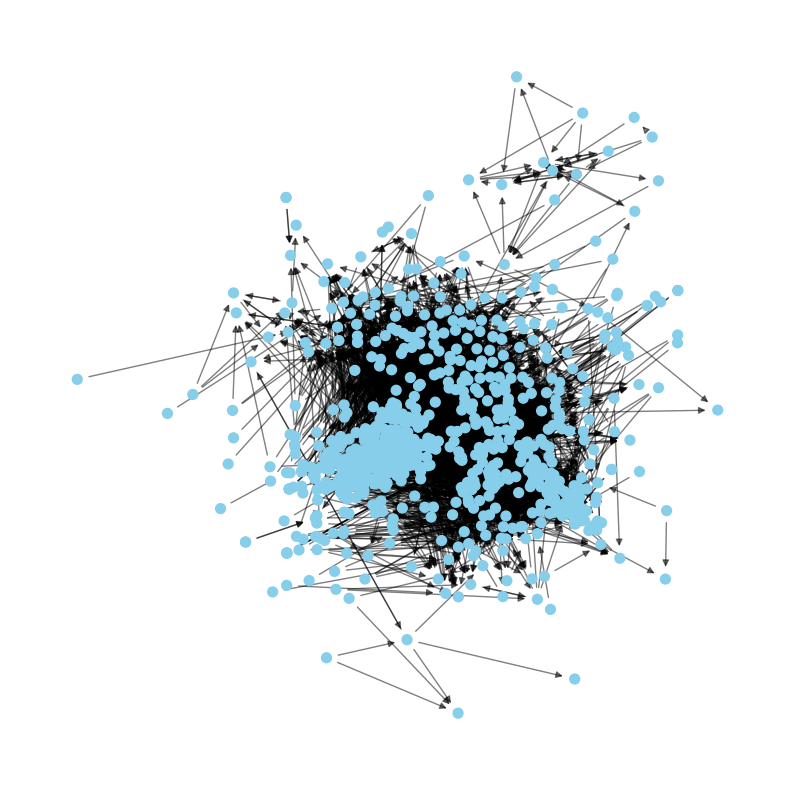

In [5]:
plot_graph(G)

In [6]:
def plot_clusters(embeddings, labels):
    """
    Function to plot the clusters using embeddings and labels from DBSCAN.

    :param embeddings: The PCA-reduced embeddings of the data.
    :param labels: The cluster labels from DBSCAN.
    """
    # Create a scatter plot of the embeddings colored by labels
    unique_labels = set(labels)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
    
    plt.figure(figsize=(12, 8))
    for label, col in zip(unique_labels, colors):
        if label == -1:
            # Use black color for noise (label == -1)
            col = 'k'
            marker = 'x'  # Use a different marker for noise points
            label_class = 'Noise'
        else:
            marker = 'o'
            label_class = f'Cluster {label}'
        
        class_member_mask = (labels == label)
        xy = embeddings[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=col,
                 markeredgecolor='k', markersize=10, label=label_class)

    plt.title('Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
def plot_tsne(data, labels, title='t-SNE plot of Clusters'):
    """
    This function applies t-SNE to reduce data dimensions and plots the result.
    
    Parameters:
    - data: ndarray, the high-dimensional data to be reduced and plotted.
    - labels: array, cluster labels for each point in `data`.
    - title: str, the title of the plot.
    """
    # Applying t-SNE to reduce dimension to 2
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(data)

    # Setting up the plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolor='k')

    # Adding color bar and labels
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.grid(True)

    # Show plot
    plt.show()


In [8]:
def plot_all_pca_components(X_, labels, n_components=5):
    """
    Plot all the principal component pairs against each other tightly.

    Parameters:
    - X_pca: The transformed data from PCA.
    - labels: The labels for the data points.
    - n_components: The number of components used in PCA.
    """

    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_)

    # Set up the matplotlib figure and axes, based on the number of components
    fig, axes = plt.subplots(n_components, n_components, figsize=(15, 15))
    
    # Color map
    cmap = plt.get_cmap('viridis', np.unique(labels).max() + 1)

    # Plot the scatter plots for each combination of components
    for i in range(n_components):
        for j in range(n_components):
            ax = axes[i, j]            
            
            scatter = ax.scatter(X_pca[:, i], X_pca[:, j], c=labels, cmap=cmap, s=30, alpha=0.6)
            ax.set_xlabel(f'Component {i+1}', fontsize=9)
            ax.set_ylabel(f'Component {j+1}', fontsize=9)
            
                

    # Color bar for labels
    # cbar = plt.colorbar(scatter, ax=axes[:, -1], location='right', shrink=0.95)
    # cbar.set_label('Labels', rotation=270, labelpad=15)

    # Set a main title for all subplots
    plt.suptitle('PCA Components vs. Each Other', fontsize=16)

    # Adjust layout to make it tight
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()



## Node2Vec

This Python implementation encapsulates the Node2Vec algorithm within a class structure. Node2Vec is designed for generating node embeddings that capture the network's topology while also considering a node's neighborhood's structure. The algorithm leverages the flexibility of random walks to explore diverse neighborhoods and uses these walks to train a Word2Vec model.

### Key Parameters:

- **`dimensions`**: The number of dimensions of the embedding space.
- **`walk_length`**: The number of steps in each random walk.
- **`num_walks`**: The number of walks to start at each node.
- **`p`** and **`q`**: Parameters which control the random walk process. `p` (return parameter) controls the likelihood of immediately revisiting a node in the walk, while `q` (in-out parameter) differentiates between inward and outward nodes in terms of walk transitions.

### Transition Probabilities:

The transition probabilities between nodes during the walks are defined as follows:

$$ P(c_i = x | c_{i-1} = v) = \begin{cases} 
\frac{\pi_{vx}}{Z} & \text{if } (v, x) \in E \\
0 & \text{otherwise} 
\end{cases} $$

Where:
- \( $\pi_{vx}$ ) represents the unnormalized transition probability between nodes \( v \) and \( x \),
- \( Z \) is a normalizing constant ensuring probabilities sum to 1 over all choices for \( x \).

The probabilities \( \pi_{vx} \) are computed based on the edge weights and the parameters \( p \) and \( q \):

$$
\pi_{vx} = \alpha_{pq}(t, x) \cdot w_{vx}
$$

Where \( w_{vx} \) is the weight of the edge from \( v \) to \( x \), and \( \alpha_{pq}(t, x) \) is given by:

$$
\alpha_{pq}(t, x) = \begin{cases} 
\frac{1}{p} & \text{if } x = t \\
1 & \text{if } x \neq t \text{ and } x \in N(t) \\
\frac{1}{q} & \text{if } x \notin N(t)
\end{cases}
$$

### Random Walk Simulation:

Random walks are simulated based on the precomputed transition probabilities. Each walk begins at a selected node and sequentially transitions to a neighboring node based on the probabilities, creating paths that reflect the local network structure.

### Model Training:

After simulating the walks, they are used to train a Word2Vec model. This model learns vector representations for each node that are useful for machine learning tasks on graphs such as node classification or clustering.

### Implementation Details:

The class `Node2Vec` includes methods to precompute transition probabilities, simulate random walks, and fit the Word2Vec model. The embeddings produced encapsulate both local and global structural information about the nodes, potentially improving performance on downstream tasks.

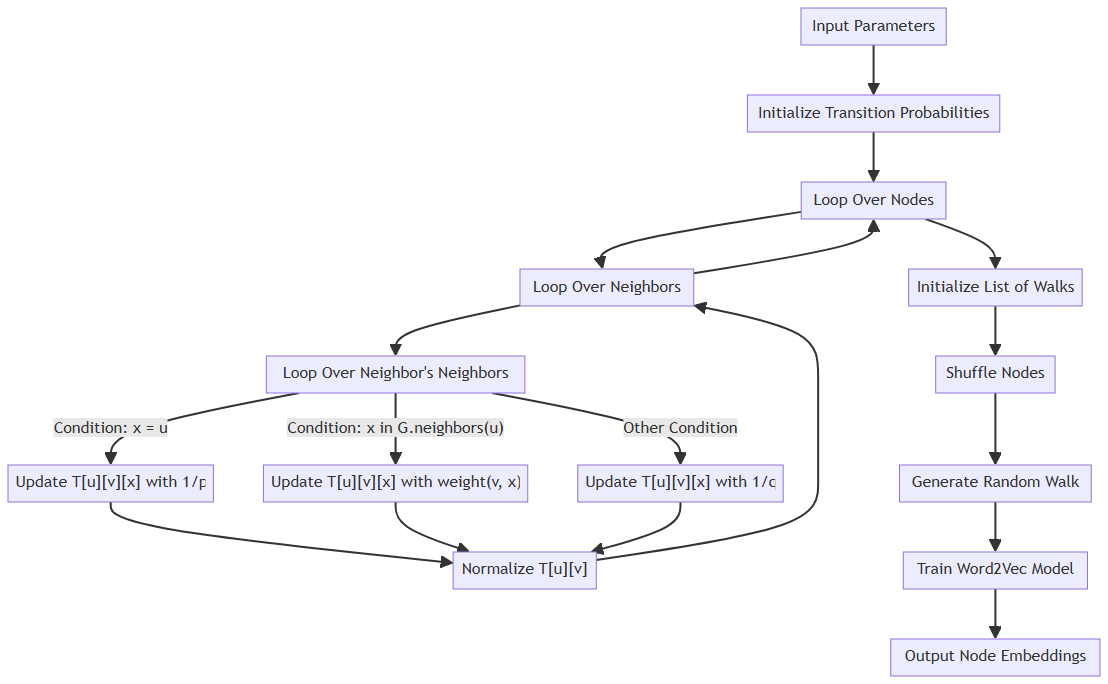


In [9]:
class Node2Vec:
    def __init__(self, graph, dimensions=64, walk_length=30, num_walks=10, p=1, q=1, workers=1):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.workers = workers
        self.transition_probs = {}

        self.precompute_transition_probs()

    def precompute_transition_probs(self):
        """
        Precompute transition probabilities for each node based on the graph structure.
        """
        for node in self.graph.nodes():
            self.transition_probs[node] = {}
            for neighbor in self.graph.neighbors(node):
                self.transition_probs[node][neighbor] = {}
                for destination in self.graph.neighbors(neighbor):
                    if destination == node:
                        prob = self.graph[neighbor][destination].get('weight', 1) * (1/self.p)
                    elif destination in self.graph[node]:
                        prob = self.graph[neighbor][destination].get('weight', 1)
                    else:
                        prob = self.graph[neighbor][destination].get('weight', 1) * (1/self.q)
                    self.transition_probs[node][neighbor][destination] = prob

                # Normalize the probabilities
                total_prob = sum(self.transition_probs[node][neighbor].values())
                for destination in self.transition_probs[node][neighbor]:
                    self.transition_probs[node][neighbor][destination] /= total_prob

    def _walk(self, start_node):
        """
        Simulate a single random walk of fixed length from a starting node.
        """
        walk = [start_node]
        while len(walk) < self.walk_length:
            cur = walk[-1]
            if len(self.graph[cur]) > 0:  # Continue walk if there are neighbors
                if len(walk) == 1:  # First step is special
                    walk.append(random.choices(
                        list(self.graph[cur]),
                        weights=[self.graph[cur][n].get('weight', 1) for n in self.graph[cur]],
                        k=1
                    )[0])
                else:
                    prev = walk[-2]
                    next_node = random.choices(
                        list(self.transition_probs[prev][cur].keys()),
                        weights=list(self.transition_probs[prev][cur].values()),
                        k=1
                    )[0]
                    walk.append(next_node)
            else:
                break
        return walk

    def simulate_walks(self):
        """
        Repeatedly simulate random walks from each node.
        """
        walks = []
        nodes = list(self.graph.nodes())
        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self._walk(node))
        return walks

    def fit(self, window=10, min_count=1, batch_words=4):
        """
        Train Word2Vec model.
        """
        walks = self.simulate_walks()
        walks = [[str(node) for node in walk] for walk in walks]  # Convert all nodes to strings
        model = Word2Vec(sentences=walks, vector_size=self.dimensions, window=window, min_count=min_count, batch_words=batch_words)
        return model



node2vec_m = Node2Vec(G, dimensions=64, walk_length=30, num_walks=500, p=1, q=1, workers=1)
model = node2vec_m.fit()


embeddings_m = {node: model.wv[str(node)] for node in  G.nodes}
print(len(embeddings_m))

799


In [10]:
# Node2Vec parameters - you might adjust these based on your dataset specifics
dimensions = 64
walk_length = 30
num_walks = 500
workers = 1

node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
model = node2vec.fit(window=10, min_count=1, batch_words=4)


In [11]:
embeddings = {node: model.wv[str(node)] for node in G.nodes}
print(len(embeddings))

799


## DBSCAN Clustering Hyperparameter Tuning

This Python script performs hyperparameter tuning to identify the optimal `eps` parameter for the DBSCAN clustering algorithm. The `eps` parameter determines the maximum distance between two samples for them to be considered as in the same neighborhood. The aim is to find the `eps` value that results in the highest number of clusters without considering outliers.

### Preprocessing:

1. **Standardization**: The feature set `X` (presumed to be a collection of embeddings) is standardized using `StandardScaler`. This normalization ensures that each feature contributes equally to the distance computation, crucial for distance-based algorithms like DBSCAN.

   $$
   X' = \frac{X - \mu}{\sigma}
   $$
   Where \( X' \) is the scaled data, \( \mu \) is the mean, and \( \sigma \) is the standard deviation.

### Hyperparameter Tuning:

2. **Exploring `eps` Values**: The `eps` values are explored over a range from 0.1 to 5, divided into 50 intervals. For each value of `eps`, the DBSCAN algorithm is executed to compute the number of clusters formed.

3. **DBSCAN Execution**:
   - DBSCAN is run with the current `eps` and a fixed `min_samples` of 3 (minimum points to form a cluster).
   - The number of clusters is determined by counting unique labels, excluding noise points (labeled as `-1`).

### Visualization:

4. **Plotting**: A line plot is generated to visualize the relationship between `eps` values and the number of clusters formed. This helps in visually identifying the `eps` value that maximizes the number of meaningful clusters.

### Results:

5. **Optimal Parameters**: The script outputs the best `eps` value and the corresponding number of clusters. This `eps` value is deemed optimal based on the criterion of maximizing the number of clusters.

By adjusting the `eps` parameter based on this analysis, the DBSCAN algorithm can be finely tuned to capture the natural clustering structure of the dataset more effectively.


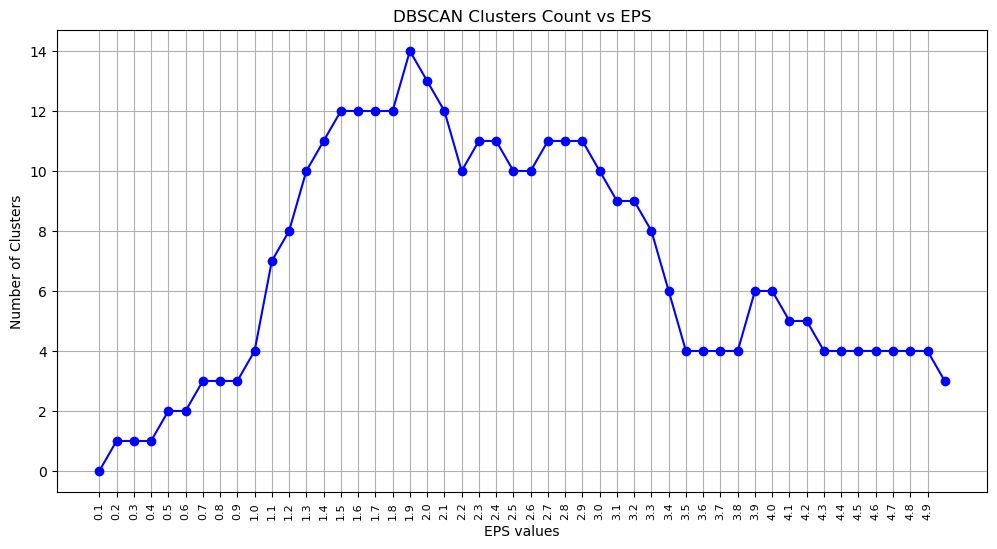

Best EPS based on hyperparameter tuning: 1.9000000000000001
Number of clusters for the best EPS: 14


In [12]:
# Hyperparameter tuning for EPS value
eps_range = np.linspace(0.1, 5, 50)
num_clusters = []
best_eps, best_cluster = 0.1, 0
X = list(embeddings_m.values())

scaler = StandardScaler()
embedding_scaled = scaler.fit_transform(X)
samples = 3
X = embedding_scaled

# Testing for max cluster EPS
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=samples)
    dbscan.fit(X)
    num_cls = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    num_clusters.append(num_cls)
    if best_cluster < num_cls:
        best_cluster = num_cls
        best_eps = eps

# Plot EPS vs Number of Clusters
plt.figure(figsize=(12, 6))
plt.plot(eps_range, num_clusters, 'o-', color='blue')
plt.xticks(np.arange(min(eps_range), max(eps_range), 0.1))
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlabel('EPS values')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN Clusters Count vs EPS')
plt.grid(True)
plt.show()

# Display the best EPS value found and the number of clusters associated
print(f"Best EPS based on hyperparameter tuning: {best_eps}")
print(f"Number of clusters for the best EPS: {best_cluster}")


In [13]:
clusters = DBSCAN(eps=best_eps, min_samples=samples)
clusters.fit(X)  
labels = clusters.labels_

num_cls = len(set(clusters.labels_)) - (1 if -1 in clusters.labels_ else 0)
print(num_cls)

14


In [14]:
set(clusters.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

### DBSCAN Results


In [15]:
def count_labels(labels):
    """
    Function to count the occurrences of each label.

    :param labels: A list or array of cluster labels.
    :return: A dictionary with labels as keys and counts as values.
    """
    label_counts = Counter(labels)
    return label_counts

# Assuming `clusters.labels_` is your list of labels from DBSCAN
label_counts = count_labels(clusters.labels_)
print(label_counts)


Counter({-1: 715, 11: 21, 1: 9, 9: 8, 2: 6, 12: 6, 0: 5, 4: 5, 7: 4, 10: 4, 13: 4, 3: 3, 5: 3, 6: 3, 8: 3})


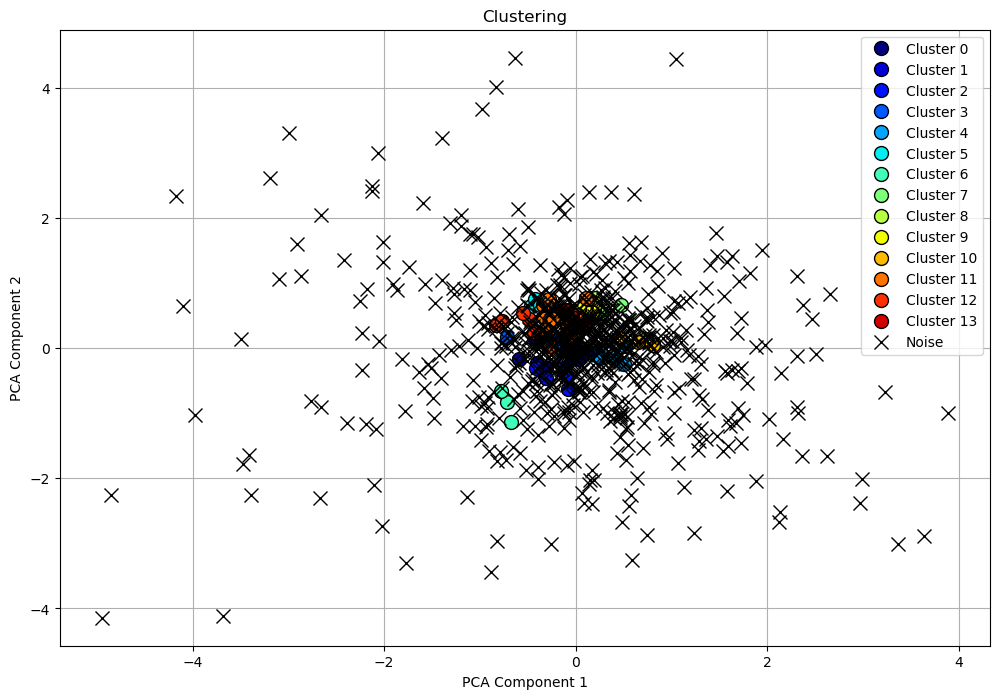

In [16]:
plot_clusters(X, clusters.labels_)


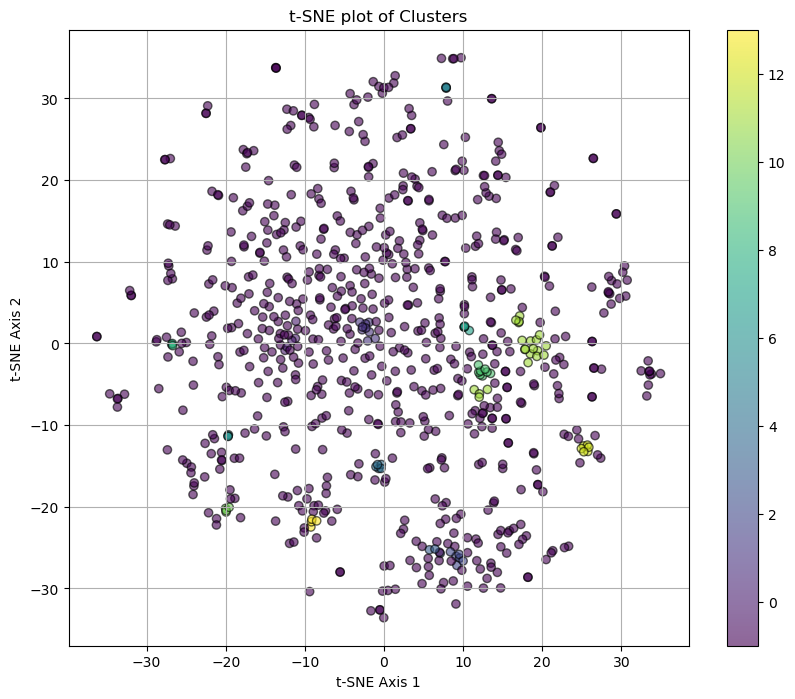

In [17]:
plot_tsne(X, clusters.labels_)

### Clustering Evaluation Metrics

The effectiveness of the DBSCAN clustering algorithm is evaluated using three different metrics, each providing insights into different aspects of the clustering quality:

#### Silhouette Score
- **Range**: -1 to 1
- **Interpretation**: A higher score indicates that clusters are compact and well-separated compared to other clusters. A score close to 1 denotes that clusters are dense and well-separated. A score near 0 indicates overlapping clusters, and a negative score suggests that samples might have been assigned to the wrong clusters.

#### Calinski-Harabasz Index
- **Interpretation**: A higher score is better. It signifies that the clusters are dense and well-separated. This index is particularly useful for datasets with clusters of roughly equal size.

#### Davies-Bouldin Index
- **Range**: 0 to Infinity
- **Interpretation**: A lower index indicates better clustering. This index evaluates how much the clusters are separated and how compact they are, with lower values showing better clustering performance.

These metrics collectively provide a comprehensive view of the clustering performance, helping to understand the strengths and weaknesses of the applied clustering approach. The scores are computed for the DBSCAN algorithm's results, reflecting how well it has identified dense and distinct clusters within the dataset.


In [18]:
# Assuming 'X' is your dataset and 'clusters.labels_' are the labels from DBSCAN
def matices(X, labels):
    silhouette_avg = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    metrics = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'],
        'Score': [silhouette_avg, ch_score, db_index]
    })
    
    return metrics
    # print(table.strip())  # Using strip() to remove any leading/trailing whitespace

matices(X,clusters.labels_)

Metric     Score
0         Silhouette Score -0.319318
1  Calinski-Harabasz Index  1.079690
2     Davies-Bouldin Index  3.649824

### K Means

This code snippet defines a function `KMeansClassFinder` that is designed to determine the optimal number of clusters for a dataset using the Elbow Method, a popular heuristic in KMeans clustering. The function takes two parameters: `X`, which is the dataset to be clustered, and `n_classes`, which defines the range for the number of clusters to test (from 1 to `n_classes - 1`).

Within the function:
- **WCSS Calculation:** It first initializes an empty list `wcss` to store the within-cluster sum of squares (WCSS). WCSS is a measure of the compactness of the clusters, with lower values generally indicating better clustering.
- **KMeans Iteration:** The function then iterates over the specified range of cluster numbers. For each possible number of clusters, it initializes a KMeans clustering with parameters `init='k-means++'` for efficient centroid placement, `max_iter=300` for a maximum number of iterations, `n_init=10` for multiple initial centroid seeds, and a fixed `random_state=0` for reproducibility. It then fits the KMeans algorithm to the dataset `X` and appends the inertia (WCSS) of the resulting model to the `wcss` list.
- **Elbow Plotting:** After calculating WCSS for each cluster number, the function plots these values against the number of clusters using matplotlib. The plot is sized 10x8 inches and is labeled appropriately, including a title 'The Elbow Method'. The elbow point in the plot, where the rate of decrease in WCSS sharply shifts, can indicate the optimal number of clusters.

The function is finally called with the dataset `X` and an upper limit of 11 for the number of clusters to be examined. This approach allows for a visual inspection of the WCSS to identify the best cluster count based on the Elbow Method.


c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

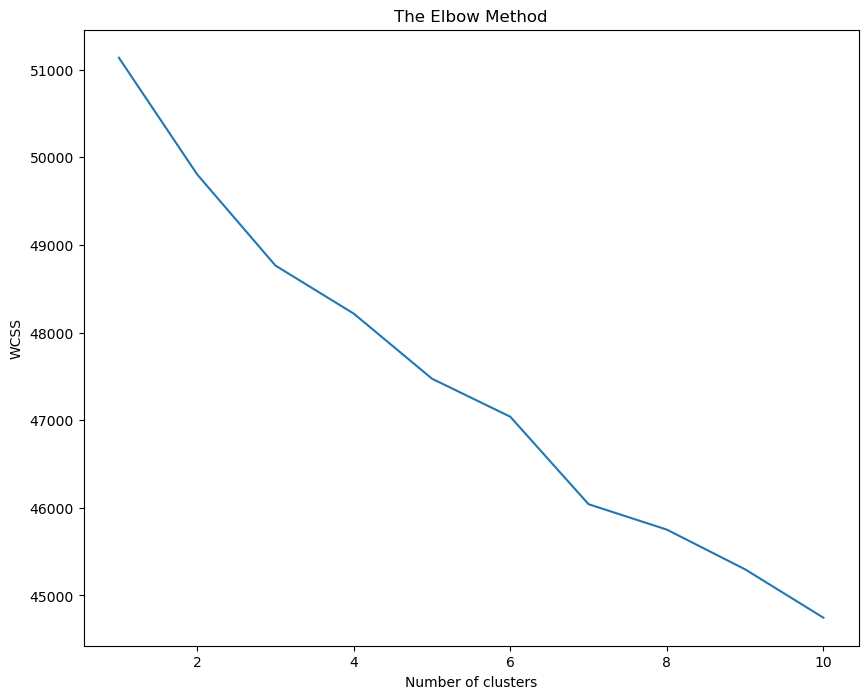

In [19]:
def KMeansClassFinder(X, n_classes):
# Calculating WCSS values for 1 to 10 clusters
    wcss = []
    for i in range(1, n_classes):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Plotting the results onto a line graph to observe 'The Elbow'
    plt.figure(figsize=(10,8))
    plt.plot(range(1, 11), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') # Within cluster sum of squares
    plt.show()

KMeansClassFinder(X, 11)

c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

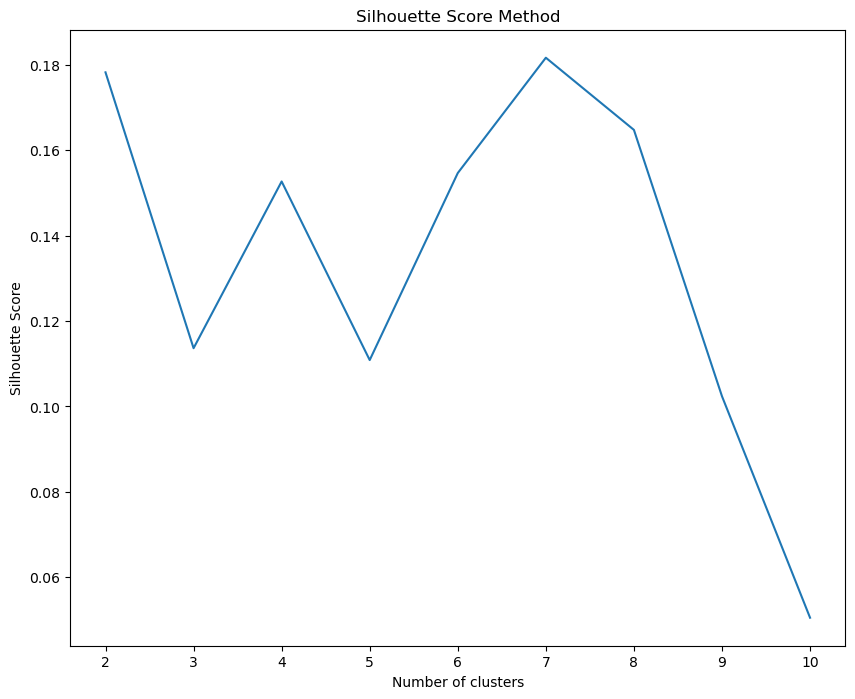

In [20]:
def KMeansClassFinder_silhouette_scores(X):
    silhouette_scores = [] 
    for i in range(2, 11): # Silhouette score can't be calculated for one cluster
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)

    # Plotting the results
    plt.figure(figsize=(10,8))
    plt.plot(range(2, 11), silhouette_scores)
    plt.title('Silhouette Score Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

KMeansClassFinder_silhouette_scores(X)

In [21]:
# Assuming X is your dataset
def applyKMeans(X, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    k_clusters = kmeans.fit(X)
    print(set(k_clusters.labels_))
    return k_clusters

k_clusters = applyKMeans(X, 10)

c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [22]:
count_labels(k_clusters.labels_)


Counter({5: 458, 0: 68, 7: 63, 1: 61, 8: 43, 4: 38, 3: 30, 9: 24, 2: 11, 6: 3})

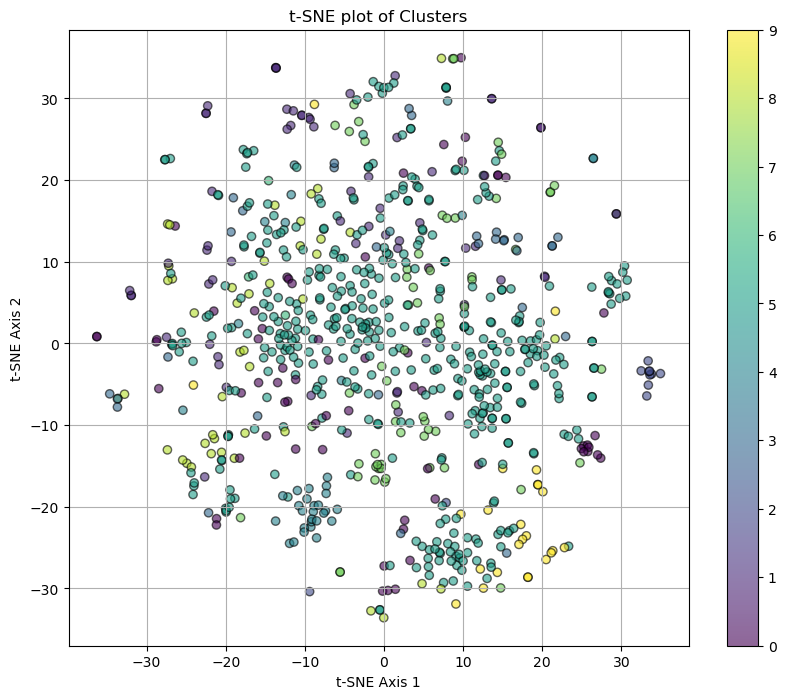

In [23]:
plot_tsne(X, k_clusters.labels_)

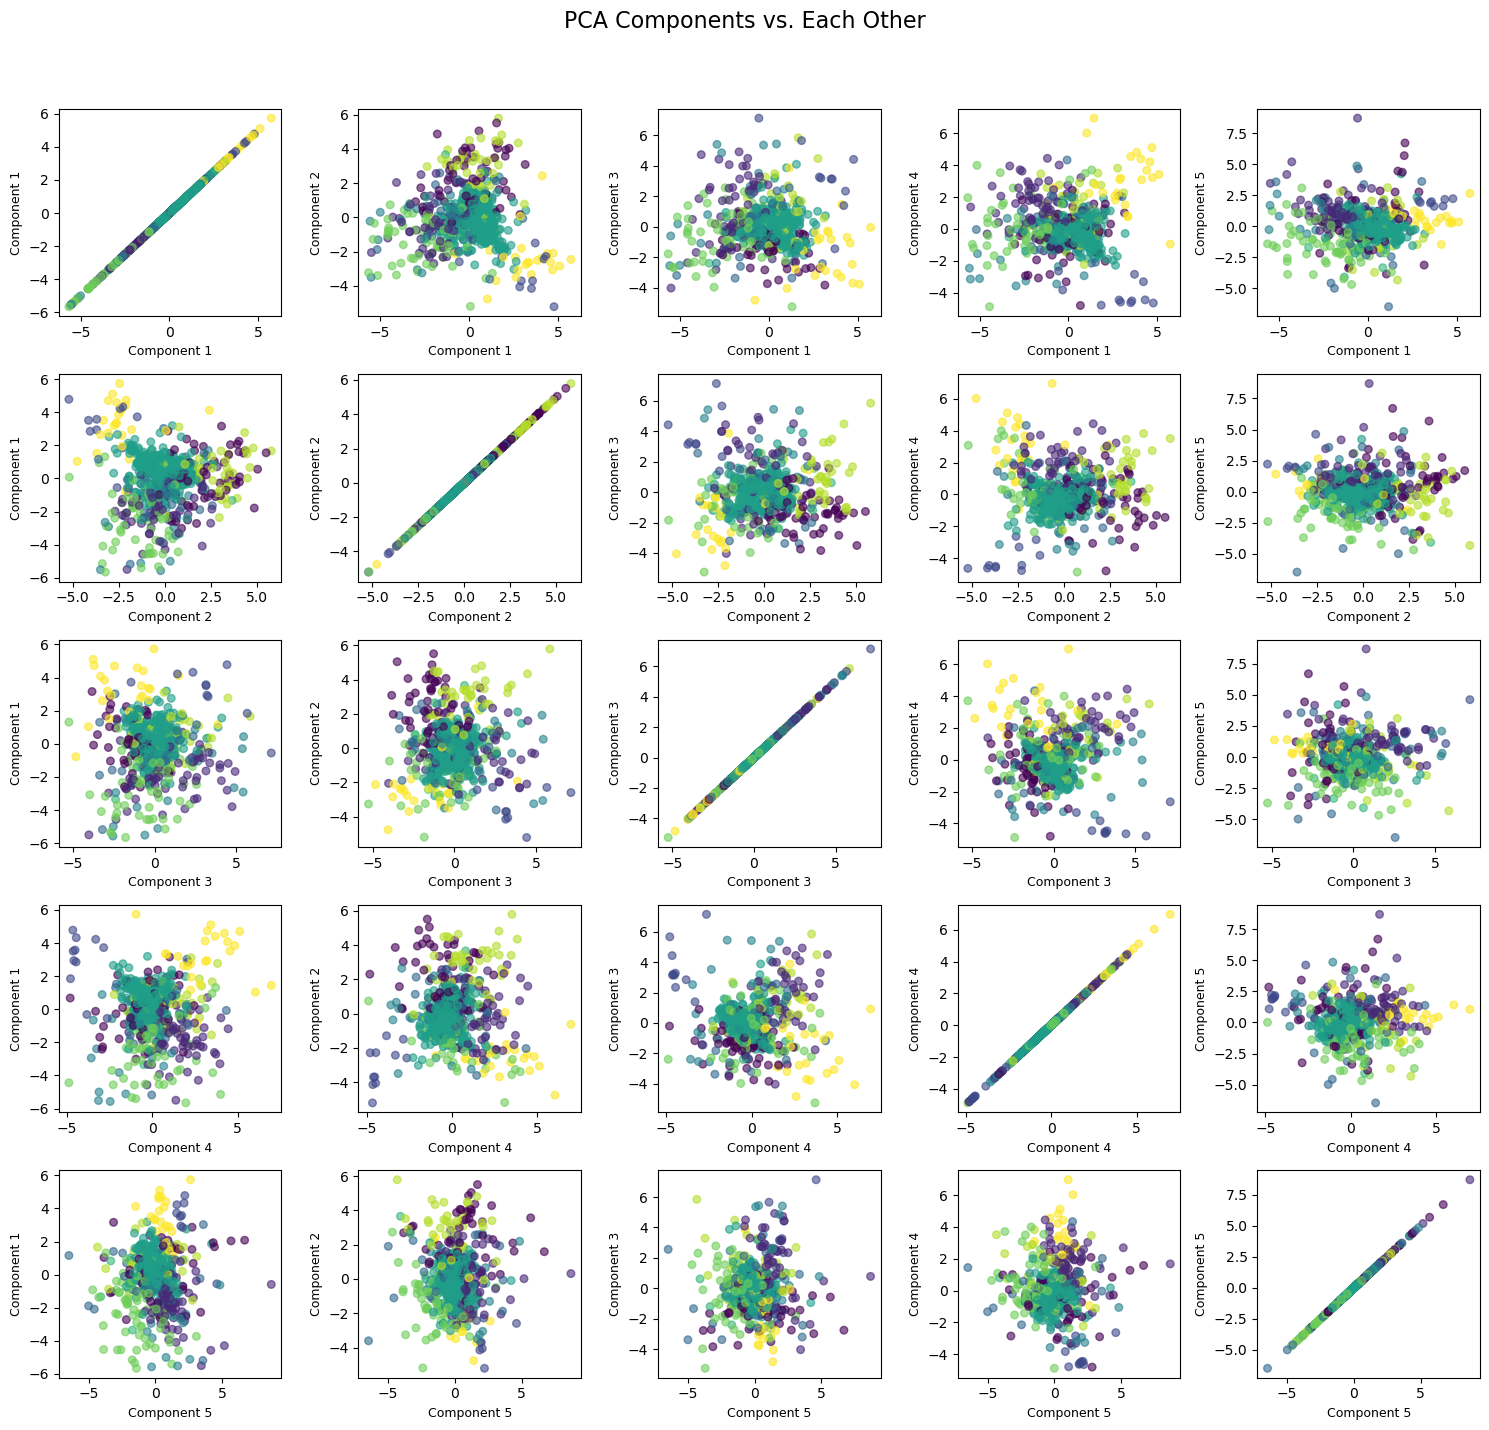

In [24]:
plot_all_pca_components(X, k_clusters.labels_, n_components=5)

### Evulation metrics

In [25]:
matices(X, k_clusters.labels_)

Metric      Score
0         Silhouette Score   0.150063
1  Calinski-Harabasz Index  12.485185
2     Davies-Bouldin Index   3.426045

### Hierarchical Clustering and Dendrogram Visualization

This Python code snippet utilizes the `linkage` method from the `scipy.cluster.hierarchy` module to perform hierarchical clustering using the Ward linkage method. The Ward method minimizes the variance of the clusters being merged, making it well-suited for identifying clusters that are relatively compact and equal in size.

### Function `plot_dendrogram`

- **Parameters**: 
  - `X`: A data matrix where samples are rows and features are columns.
  
- **Process**:
  1. **Linkage Computation**: The `linkage()` function computes hierarchical clusters using the 'ward' method, which is a common approach for hierarchical agglomerative clustering (HAC). This method is particularly effective for creating clusters by minimizing the total within-cluster variance. At each step, the pair of clusters with the minimum between-cluster distance are merged.
  2. **Dendrogram Plotting**: The resulting linkage array, which contains the hierarchical clustering information, is used to plot a dendrogram. The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children.
  
- **Visualization Settings**:
  - `orientation='top'`: This places the root at the top, and items are displayed from top to bottom.
  - `distance_sort='descending'`: This sorts the distances between pairs of clusters in descending order, aiding in the visualization of the most distinct clusters.
  - `show_leaf_counts=True`: This option adds the number of items in each node, providing a clear view of the cluster sizes at a glance.

- **Plot Customization**:
  The plot is adjusted to a size of 10x7 inches to ensure all elements of the dendrogram are clearly visible, making it suitable for detailed analysis or presentations.

The function returns the linkage matrix, which can be used for further analysis or for plotting additional dendrograms with different configurations.

### Example Usage
The function `plot_dendrogram` is called with the dataset `X`, and the linkage matrix `linked` is stored for potential further analysis. This methodology provides a profound insight into the data's hierarchical structure, which is crucial for understanding natural groupings within the dataset.


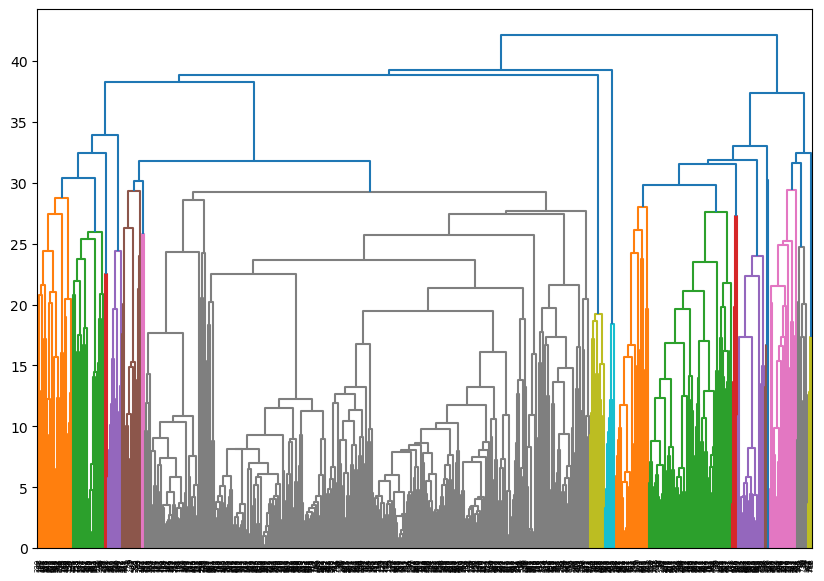

In [26]:
# Assuming X is your data matrix with samples as rows
# Use the 'ward' linkage method to compute the clusters
def plot_dendrogram(X):
    linked = linkage(X, 'ward')

    # Plot the hierarchical clustering as a dendrogram.
    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                distance_sort='descending',
                show_leaf_counts=True)
    plt.show()
    return linked
linked = plot_dendrogram(X)

In [27]:
def applyFcluster(linked, max_d):    
    fclusters = fcluster(linked, max_d, criterion='distance')
    print(set(fclusters))  # Prints cluster labels for each point
    return fclusters

fclusters = applyFcluster(linked, 35)

{1, 2, 3, 4, 5, 6}


In [28]:
count_labels(fclusters)

Counter({5: 482, 2: 159, 6: 87, 1: 45, 4: 16, 3: 10})

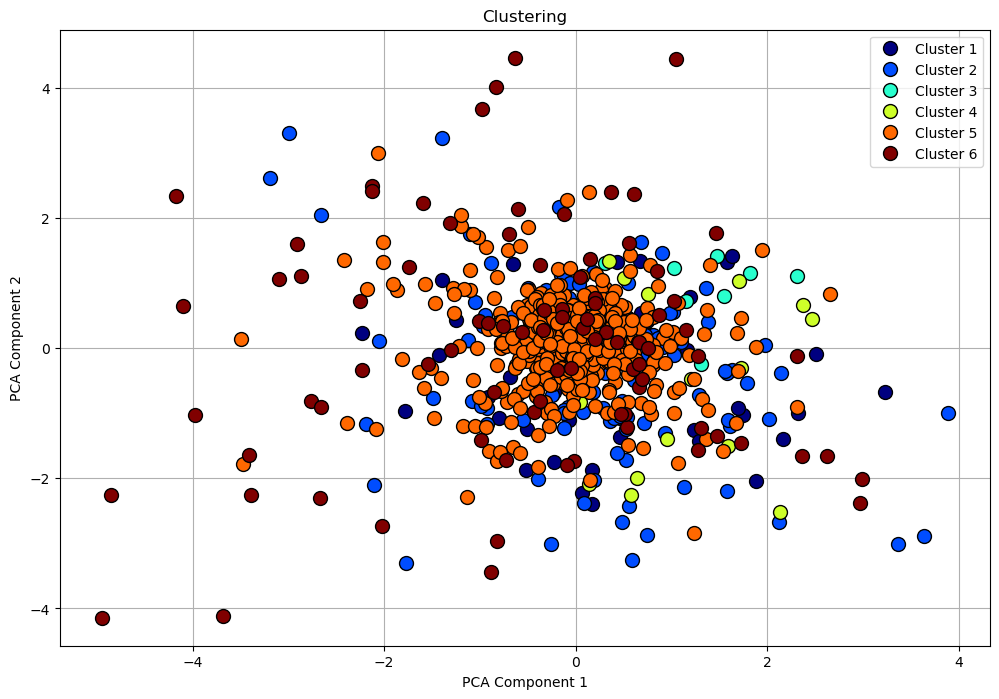

In [29]:
plot_clusters(X, fclusters)


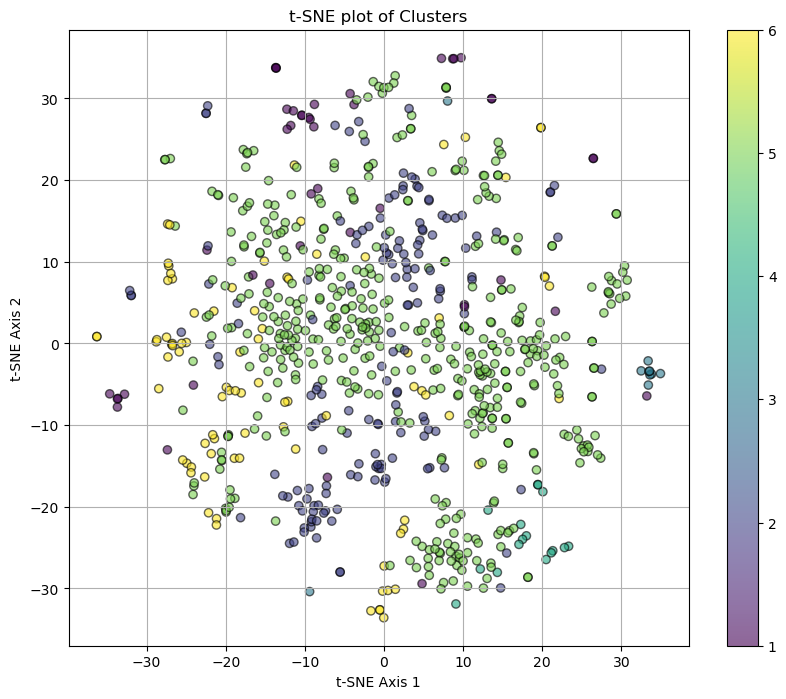

In [30]:
plot_tsne(X, fclusters)

### Evulation metric

In [31]:
matices(X, fclusters)

Metric      Score
0         Silhouette Score   0.100648
1  Calinski-Harabasz Index  12.903035
2     Davies-Bouldin Index   3.897753

## GCN
The provided Python script is part of a process for setting up graph data in a format suitable for use with machine learning frameworks that deal with graph-based data, like PyTorch Geometric. Here's a breakdown of what each part of the script does:

1. **Feature Matrix Creation**:
   - The script creates a feature matrix where each feature is the degree of a node. It collects the degrees of nodes in a sorted order, converts them into a PyTorch tensor of floats, and adds an extra dimension to make it a column vector.
   - This is done with the line `features = torch.tensor([G.degree(node) for node in sorted(G.nodes)], dtype=torch.float).unsqueeze(1)`.

2. **Edge Index Tensor**:
   - An edge index tensor is created from the list of edges in the graph `G`. The tensor is converted to a long data type and then transposed to ensure the shape matches PyTorch Geometric's expectations (two rows where each column is an edge and rows represent source and target nodes respectively).
   - This tensor is made contiguous for performance reasons in memory, using `edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()`.

3. **Graph Data Object**:
   - A `Data` object (assuming from PyTorch Geometric) is instantiated with the node features `x` and the edge index `edge_index`. This object conveniently packages the graph data for processing in graph neural networks.
   - The setup is demonstrated with `data = Data(x=features, edge_index=edge_index)`.

4. **Function to Remap Edge Indices**:
   - The function `remap_edges` takes an edge index tensor and a dictionary mapping old node indices to new ones. It iterates through each edge, updating indices based on the mapping, ensuring the edge indices align with new or reordered node indices.
   - This function is critical in cases where node indices may have been changed or reordered and is applied to the graph data with `data.edge_index = remap_edges(data.edge_index, node_to_index)`.

5. **Output**:
   - Finally, the script prints the `data` object to display its structure and contents, which include the node features and the possibly remapped edge indices.

This script is particularly useful for preparing graph data for training graph neural networks, where node features and correct edge connections are crucial.
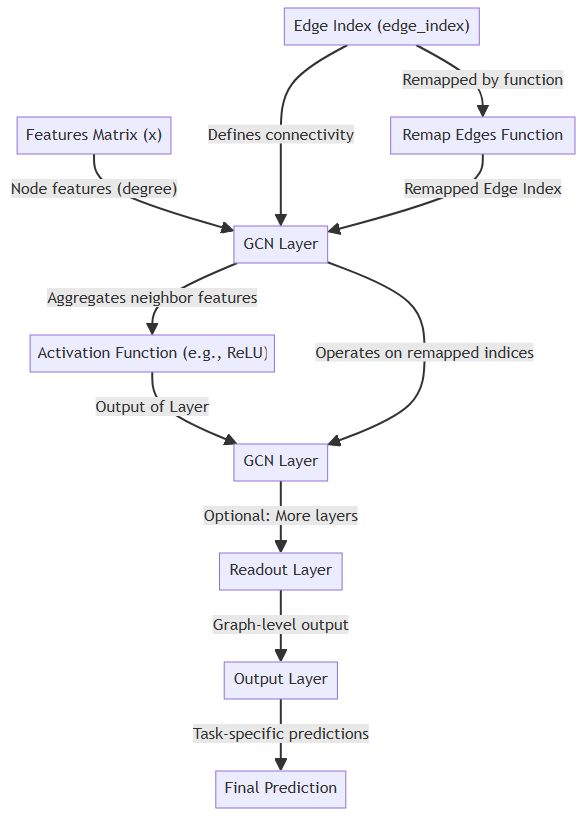

In [32]:
# Create a feature matrix with node degrees as features
features = torch.tensor([G.degree(node) for node in sorted(G.nodes)], dtype=torch.float).unsqueeze(1)

# Create an edge index tensor
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

# Assuming all nodes are part of the same graph and unlabelled
data = Data(x=features, edge_index=edge_index)

# Function to remap edge indices
def remap_edges(edge_index, node_to_index):
    for i in range(edge_index.size(1)):
        edge_index[0, i] = node_to_index[edge_index[0, i].item()]
        edge_index[1, i] = node_to_index[edge_index[1, i].item()]
    return edge_index

# Assuming 'data.edge_index' is your original edge index tensor
data.edge_index = remap_edges(data.edge_index, node_to_index)



print(data)

Data(x=[799, 1], edge_index=[2, 5358])


In [33]:
edge_index_max = data.edge_index.max()
num_nodes = data.x.size(0)  # Assuming 'data.x' represents node features for each node

print(f"Maximum node index in 'edge_index': {edge_index_max}")
print(f"Number of nodes based on 'data.x': {num_nodes}")

if edge_index_max >= num_nodes:
    raise ValueError("Edge index out of bounds. Make sure all indices are within the number of nodes.")


Maximum node index in 'edge_index': 798
Number of nodes based on 'data.x': 799


In [34]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class InnerProductDecoder(torch.nn.Module):
    """Decoding node embeddings to reconstruct the graph."""
    def forward(self, z, edge_index, sigmoid=True):
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

class GraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GCNEncoder(in_channels, out_channels)
        self.decoder = InnerProductDecoder()

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        return self.decoder(z, edge_index)

# Load your graph data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
num_features = data.num_features
out_features = 64  # Dimensionality of the output embeddings
model = GraphAutoencoder(num_features, out_features).to(device)
data = data.to(device)  # Assuming 'data' is your input dataset that has x, edge_index
optimizer = Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encoder(data.x.to(device), data.edge_index.to(device))
    edge_index, link_labels = get_link_labels(data.edge_index, data.num_nodes)
    link_logits = model.decoder(z, edge_index.to(device))
    link_labels = link_labels.to(device)
    loss = F.binary_cross_entropy(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def get_link_labels(pos_edge_index, num_nodes):
    # Remove self-loops if they exist
    pos_edge_index, _ = remove_self_loops(pos_edge_index)
    # Add self-loops back to preserve the main diagonal if needed
    pos_edge_index, _ = add_self_loops(pos_edge_index)
    # Sample negative edges
    neg_edge_index = negative_sampling(pos_edge_index, num_nodes, num_neg_samples=pos_edge_index.size(1))
    
    # Concatenate positive and negative samples
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    
    # Create link labels: 1 for existing edges, 0 for negative samples
    link_labels = torch.cat([torch.ones(pos_edge_index.size(1), dtype=torch.float),
                             torch.zeros(neg_edge_index.size(1), dtype=torch.float)], dim=0)
    return edge_index, link_labels


# Example of a training loop
for epoch in range(200):
    loss = train()
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}')


Epoch: 1, Loss: 40.1179
Epoch: 2, Loss: 31.4031
Epoch: 3, Loss: 17.9443
Epoch: 4, Loss: 16.0224
Epoch: 5, Loss: 16.1675
Epoch: 6, Loss: 15.1585
Epoch: 7, Loss: 9.8795
Epoch: 8, Loss: 5.1327
Epoch: 9, Loss: 6.9878
Epoch: 10, Loss: 7.0480
Epoch: 11, Loss: 3.8040
Epoch: 12, Loss: 2.1236
Epoch: 13, Loss: 2.0728
Epoch: 14, Loss: 2.3655
Epoch: 15, Loss: 1.5440
Epoch: 16, Loss: 1.0220
Epoch: 17, Loss: 1.2008
Epoch: 18, Loss: 1.0054
Epoch: 19, Loss: 0.8858
Epoch: 20, Loss: 0.7852
Epoch: 21, Loss: 0.7425
Epoch: 22, Loss: 0.7684
Epoch: 23, Loss: 0.7503
Epoch: 24, Loss: 0.7175
Epoch: 25, Loss: 0.6733
Epoch: 26, Loss: 0.6607
Epoch: 27, Loss: 0.6976
Epoch: 28, Loss: 0.6808
Epoch: 29, Loss: 0.6529
Epoch: 30, Loss: 0.6354
Epoch: 31, Loss: 0.6490
Epoch: 32, Loss: 0.6539
Epoch: 33, Loss: 0.6360
Epoch: 34, Loss: 0.6320
Epoch: 35, Loss: 0.6361
Epoch: 36, Loss: 0.6338
Epoch: 37, Loss: 0.6328
Epoch: 38, Loss: 0.6313
Epoch: 39, Loss: 0.6284
Epoch: 40, Loss: 0.6337
Epoch: 41, Loss: 0.6317
Epoch: 42, Loss: 0.

In [35]:
model.eval()  # Set the model to evaluation mode to disable dropout layers
with torch.no_grad():  # Disable gradient computation
    embeddings_gcn = model.encoder(data.x.to(device), data.edge_index.to(device))


In [36]:
print(len(embeddings_gcn))

799


### K-Means

c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

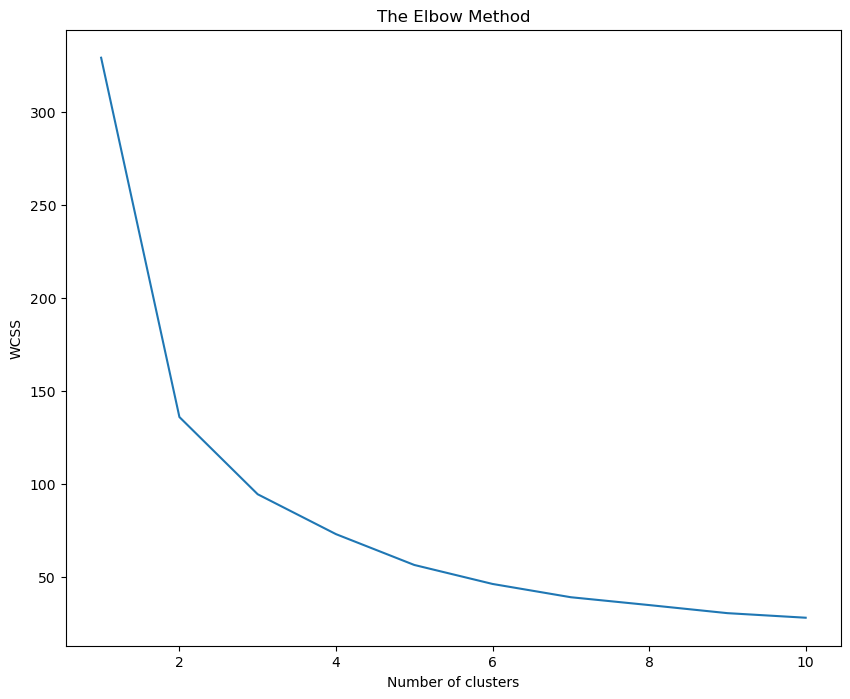

In [37]:
embeddings_np_gcn = embeddings_gcn.cpu().detach().numpy()

KMeansClassFinder(embeddings_np_gcn, 11)


c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

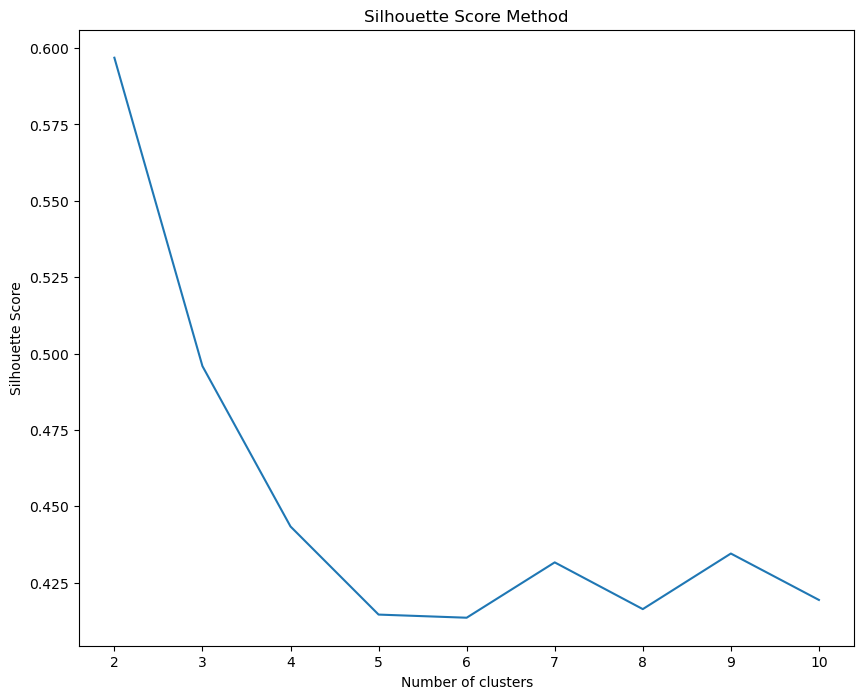

In [38]:
KMeansClassFinder_silhouette_scores(embeddings_np_gcn)

In [39]:
gcn_kclusters = applyKMeans(embeddings_np_gcn, 4)


c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


{0, 1, 2, 3}


In [40]:
count_labels(gcn_kclusters.labels_)

Counter({3: 439, 0: 203, 2: 81, 1: 76})

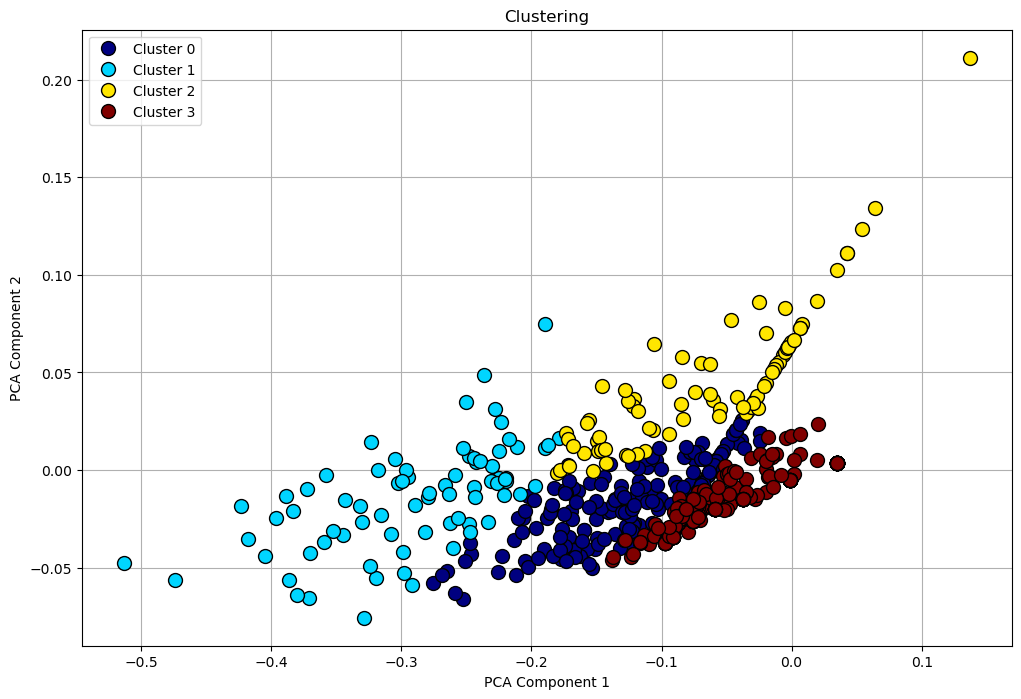

In [41]:
plot_clusters(embeddings_np_gcn, gcn_kclusters.labels_)

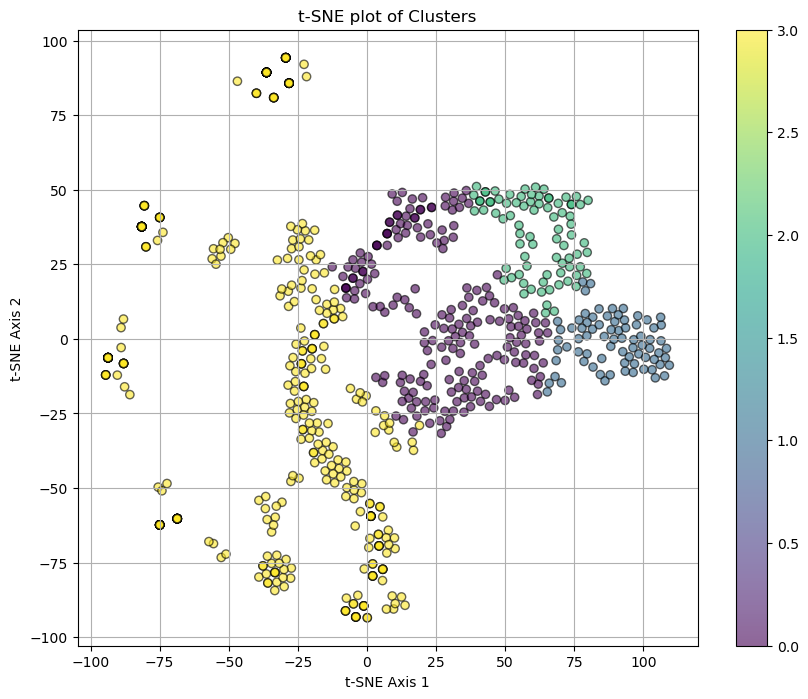

In [42]:
plot_tsne(embeddings_np_gcn, gcn_kclusters.labels_)

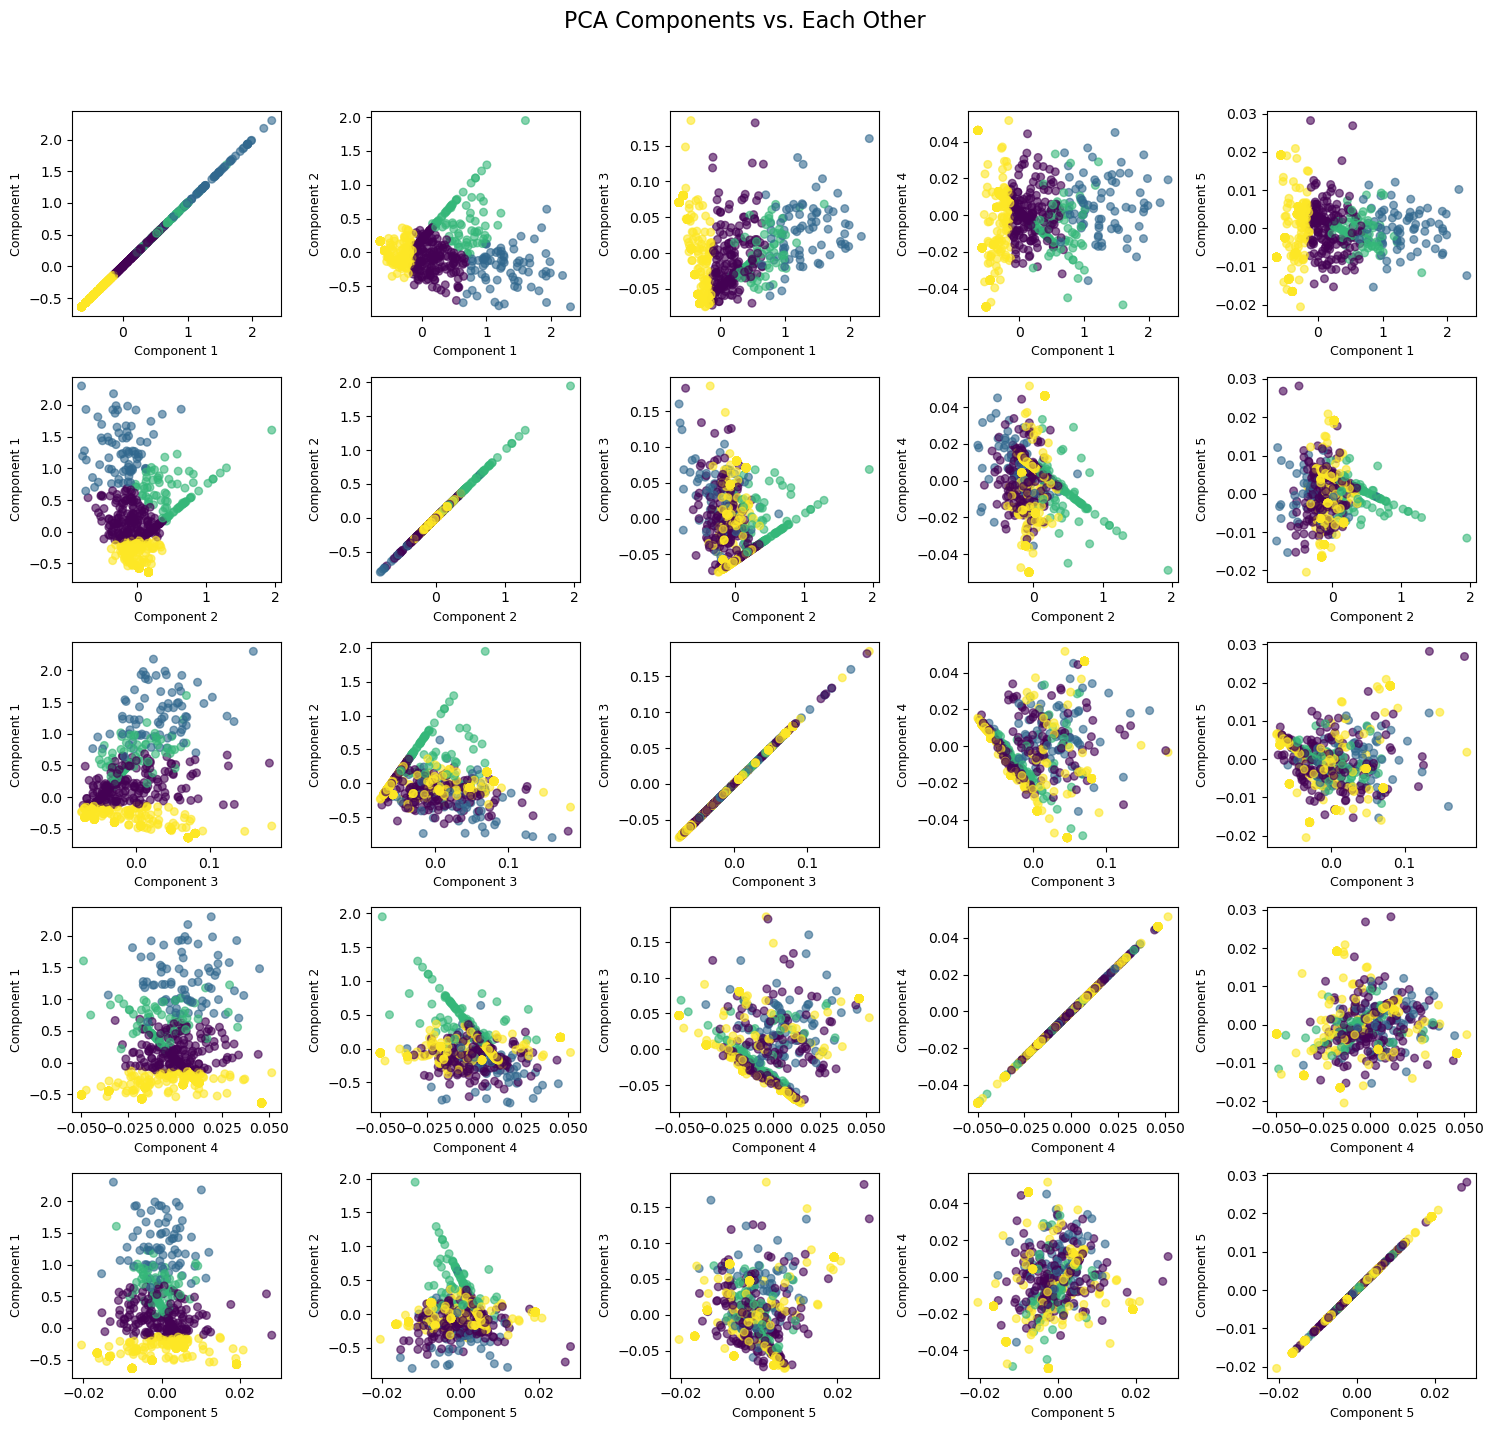

In [43]:
plot_all_pca_components(embeddings_np_gcn, gcn_kclusters.labels_, n_components=5)

In [44]:
matices(X,  gcn_kclusters.labels_)

Metric      Score
0         Silhouette Score   0.071329
1  Calinski-Harabasz Index   4.046779
2     Davies-Bouldin Index  10.459836

### Hierarchical Clustering

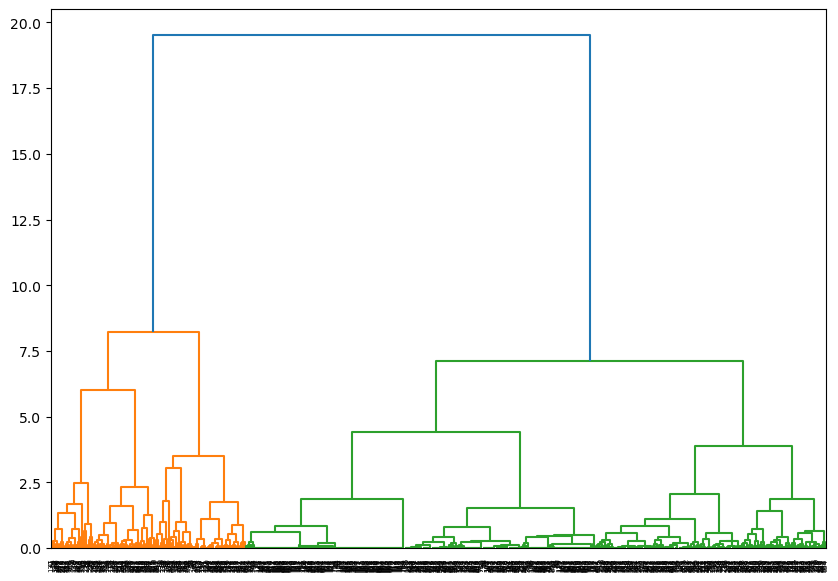

In [45]:
linked_gcn = plot_dendrogram(embeddings_np_gcn)

In [46]:
fclusters_gcn = applyFcluster(linked_gcn, 6.5)


{1, 2, 3, 4}


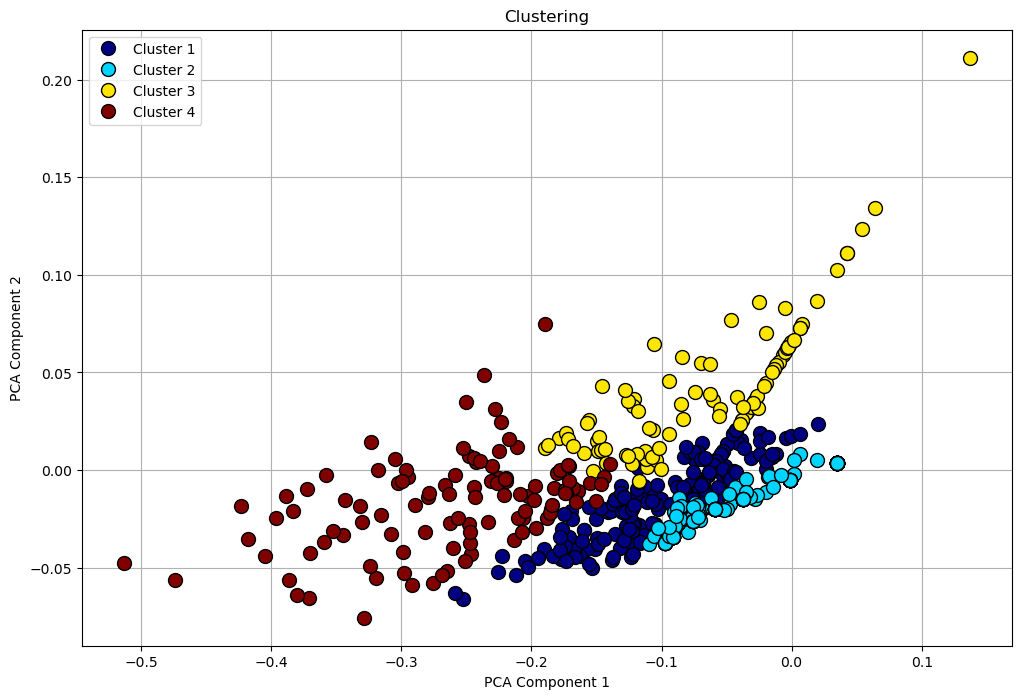

In [47]:
plot_clusters(embeddings_np_gcn, fclusters_gcn)

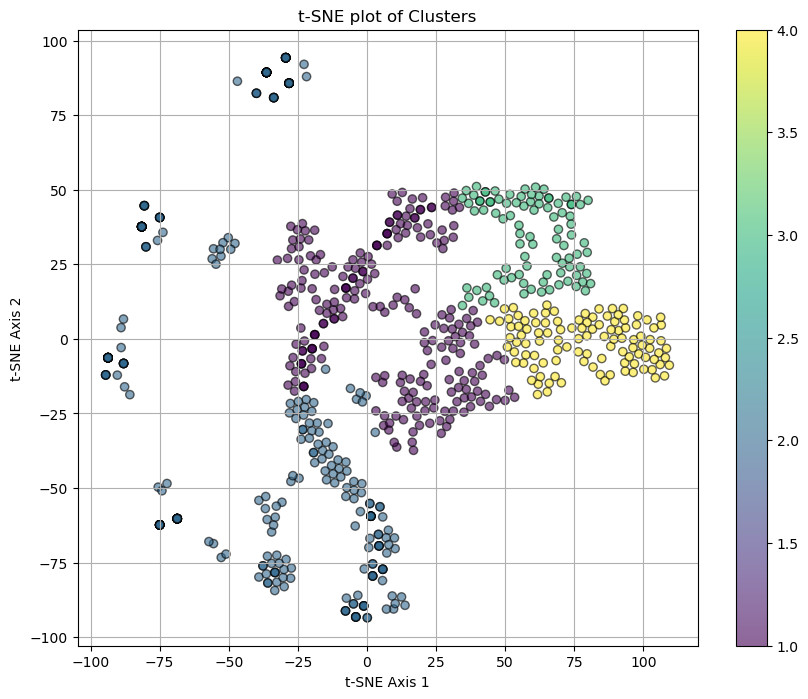

In [48]:
plot_tsne(embeddings_np_gcn, fclusters_gcn)

In [49]:
 matices(X, fclusters_gcn)

Metric      Score
0         Silhouette Score   0.014585
1  Calinski-Harabasz Index   3.726467
2     Davies-Bouldin Index  10.939329

## Spectral
The provided Python script performs spectral graph analysis using NetworkX and NumPy libraries. Here's a detailed explanation of each part of the script:

1. **Adjacency Matrix Creation**:
   - The script starts by converting a graph `G` into its adjacency matrix `A` using NetworkX's `to_numpy_array` function. The adjacency matrix `A` represents the connections between nodes, where each entry `A[i, j]` is `1` if there is an edge between node `i` and node `j`, and `0` otherwise.

2. **Degree Matrix Calculation**:
   - Next, it computes the degree matrix `D`, which is a diagonal matrix where each diagonal entry `D[i, i]` is the sum of the `i`-th row of the adjacency matrix `A`. This represents the number of connections (degree) of each node.

3. **Laplacian Matrix Computation**:
   - The Laplacian matrix `L` is calculated as `D - A`. The Laplacian matrix is a fundamental matrix in graph theory used for various applications like clustering, network analysis, and dimensionality reduction. It reflects the structure of the graph in terms of its connectivity.

4. **Eigenvalues and Eigenvectors**:
   - The script then calculates the eigenvalues and eigenvectors of the Laplacian matrix using the `eigh` function, which is optimized for symmetric matrices like `L`. The eigenvalues are sorted in increasing order since the Laplacian matrix is positive semi-definite, meaning all eigenvalues are non-negative.

5. **Spectral Embedding**:
   - To reduce the graph into a lower-dimensional space for tasks like visualization or clustering, the script selects a subset of the smallest eigenvalues (skipping the smallest trivial zero eigenvalue which represents the overall connectivity of the graph). It then uses the corresponding eigenvectors to form a `spectral_embedding`.
   - The number of dimensions for the embedding is set to 64, but this can be adjusted based on the specific application or the graph's size and complexity.

6. **Output**:
   - The script originally intended to print the smallest eigenvalues and the spectral embedding, though the actual printing of the embedding is commented out in the code provided. The user can uncomment these lines to see the embedding or modify the print statements to focus on different aspects of the output, such as specific eigenvectors or dimensions of the embedding.

This code effectively demonstrates how to perform spectral graph analysis, which is a powerful technique for understanding the structure and properties of graphs through their spectral characteristics.



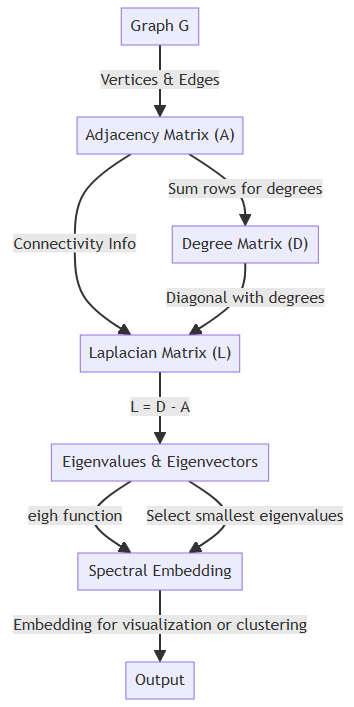

In [50]:
is_connected = nx.is_connected(G.to_undirected())
print("Is the graph connected?", is_connected)


Is the graph connected? False


In [51]:
# Step 1: Adjacency matrix
A = nx.to_numpy_array(G)

# Step 2: Degree matrix
D = np.diag(A.sum(axis=1))

# Step 3: Laplacian matrix
L = D - A

# Step 4: Eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(L)
print("Smallest eigenvalues:", len(eigenvalues))  # adjust range as needed

# Since the Laplacian matrix is positive semi-definite, the eigenvalues are non-negative.
# We sort the eigenvalues, skipping the first small trivial eigenvalue 0
# Assume we want 2 dimensions for our embedding
num_dimensions = 64
smallest_eigenvalues = np.argsort(eigenvalues)[1:num_dimensions+1]  # skip the first eigenvalue

# Corresponding eigenvectors are our spectral embedding
spectral_embedding = eigenvectors[:, smallest_eigenvalues]

# print("Spectral Embedding:\n", spectral_embedding)

# for ele in spectral_embedding:
#     print(ele)

Smallest eigenvalues: 799


### K-Means

c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

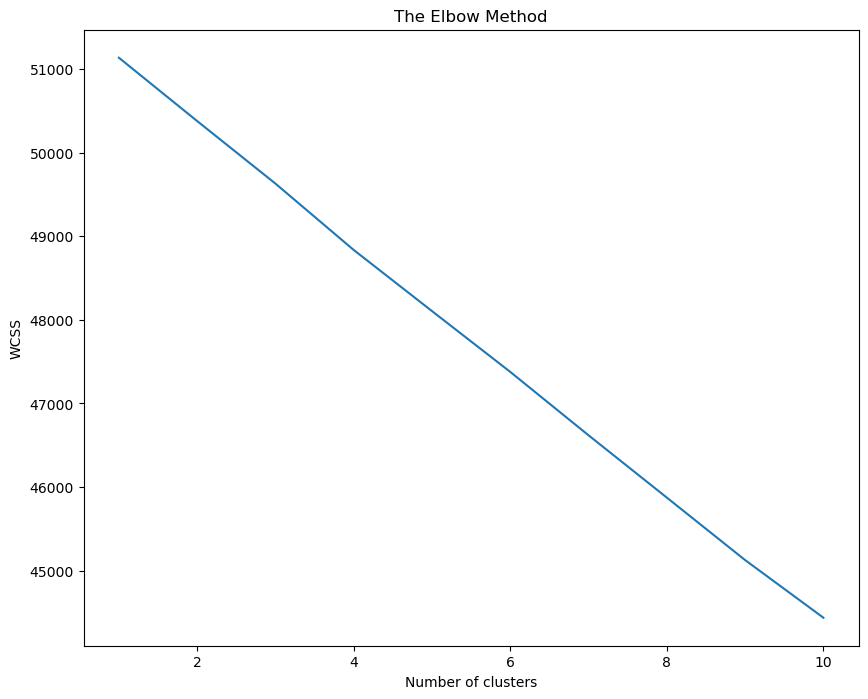

In [52]:
scaler = StandardScaler()
spectral_embedding = scaler.fit_transform(spectral_embedding)
KMeansClassFinder(spectral_embedding, 11)

c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

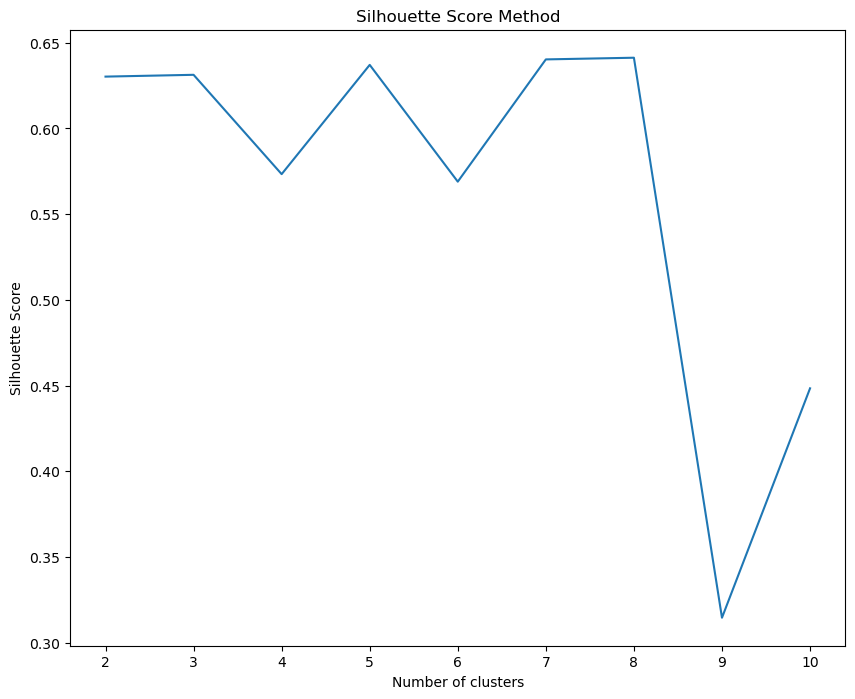

In [53]:
KMeansClassFinder_silhouette_scores(spectral_embedding)

In [54]:
spc_clusters = applyKMeans(spectral_embedding, 5)

c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gupta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


{0, 1, 2, 3, 4}


In [55]:
count_labels(spc_clusters.labels_)

Counter({0: 788, 2: 4, 4: 3, 1: 2, 3: 2})

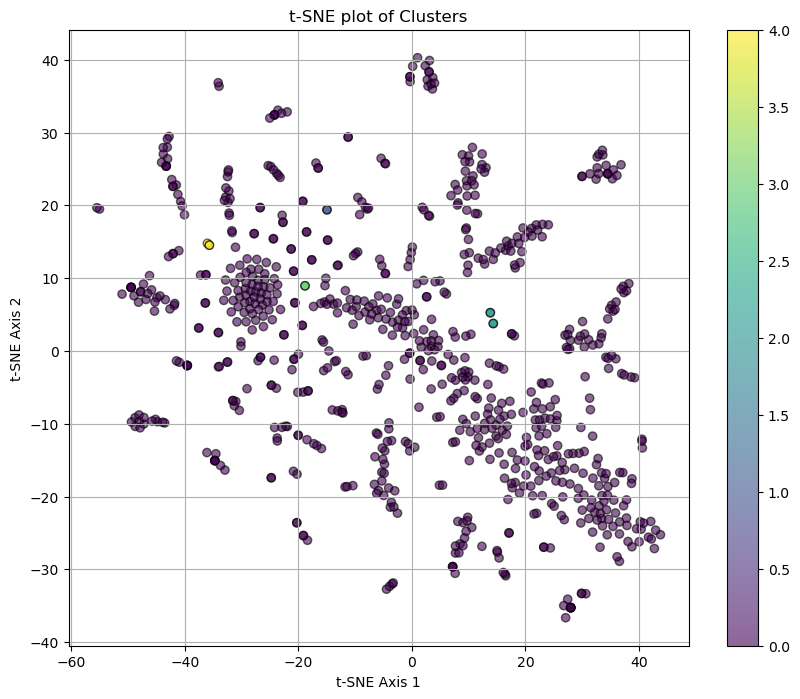

In [56]:
plot_tsne(spectral_embedding, spc_clusters.labels_)

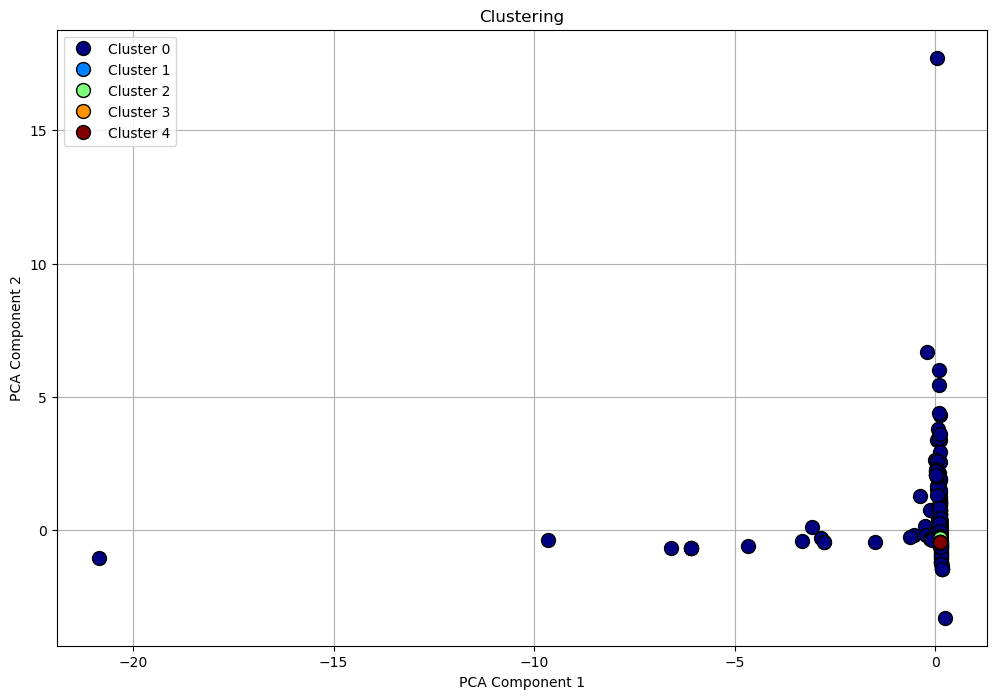

In [57]:
plot_clusters(spectral_embedding, spc_clusters.labels_)

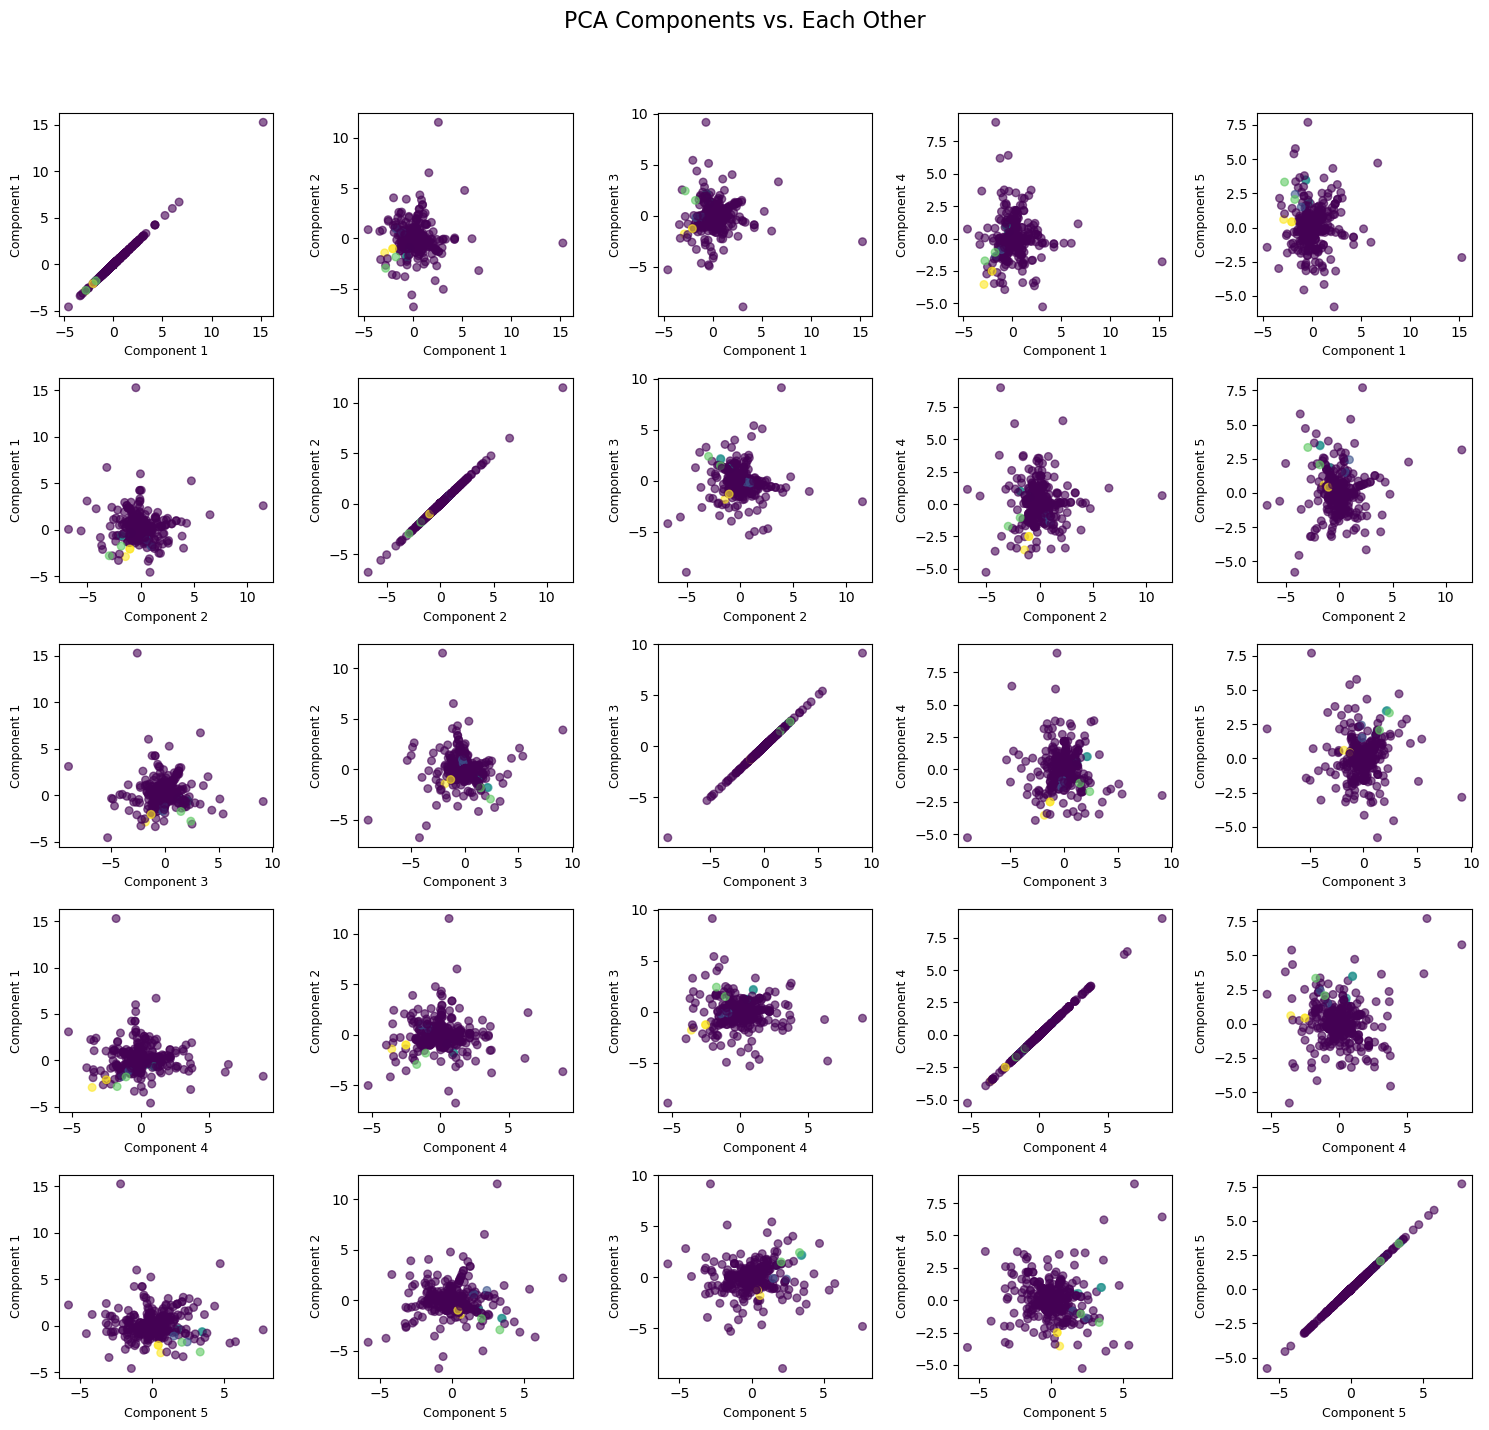

In [58]:
plot_all_pca_components(spectral_embedding, spc_clusters.labels_, n_components=5)

In [59]:
matices(X, spc_clusters.labels_)

Metric     Score
0         Silhouette Score -0.296521
1  Calinski-Harabasz Index  1.243626
2     Davies-Bouldin Index  2.344077

### Hierarchical Clustering

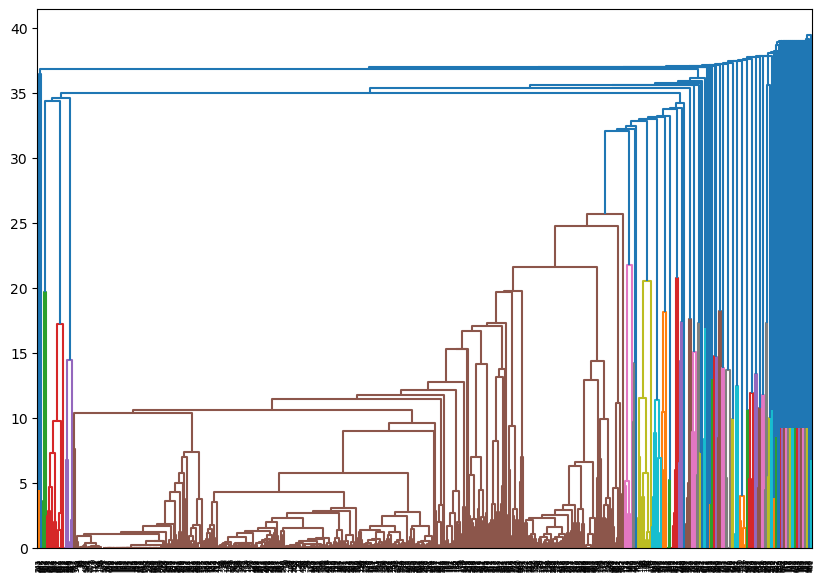

In [60]:
linked_spec = plot_dendrogram(spectral_embedding)

In [61]:
spec_fclusters = applyFcluster(linked_spec, 32)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}


In [62]:
count_labels(spec_fclusters)

Counter({50: 568,
         54: 18,
         47: 15,
         46: 10,
         53: 10,
         27: 8,
         49: 8,
         43: 8,
         41: 7,
         25: 6,
         30: 6,
         45: 6,
         28: 5,
         42: 5,
         40: 5,
         55: 5,
         22: 4,
         44: 4,
         23: 4,
         32: 4,
         48: 4,
         39: 4,
         31: 4,
         37: 4,
         57: 3,
         35: 3,
         1: 3,
         20: 3,
         29: 3,
         21: 3,
         24: 3,
         17: 3,
         15: 2,
         36: 2,
         18: 2,
         26: 2,
         38: 2,
         19: 2,
         34: 2,
         8: 2,
         7: 2,
         16: 2,
         2: 2,
         14: 2,
         33: 2,
         13: 2,
         12: 2,
         11: 2,
         10: 2,
         6: 2,
         9: 2,
         5: 2,
         4: 2,
         3: 2,
         51: 1,
         62: 1,
         56: 1,
         61: 1,
         59: 1,
         60: 1,
         58: 1,
         52: 1,
         63

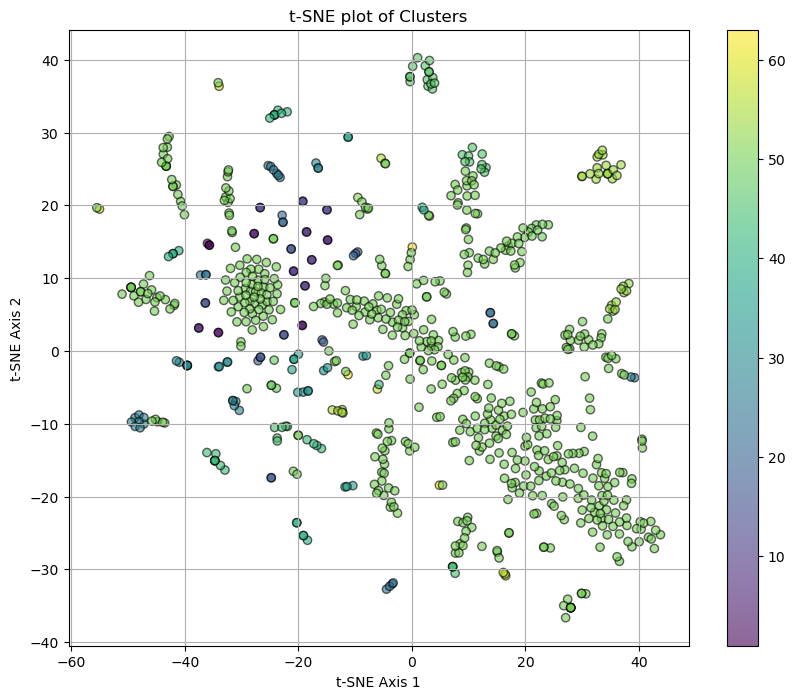

In [63]:
plot_tsne(spectral_embedding, spec_fclusters)

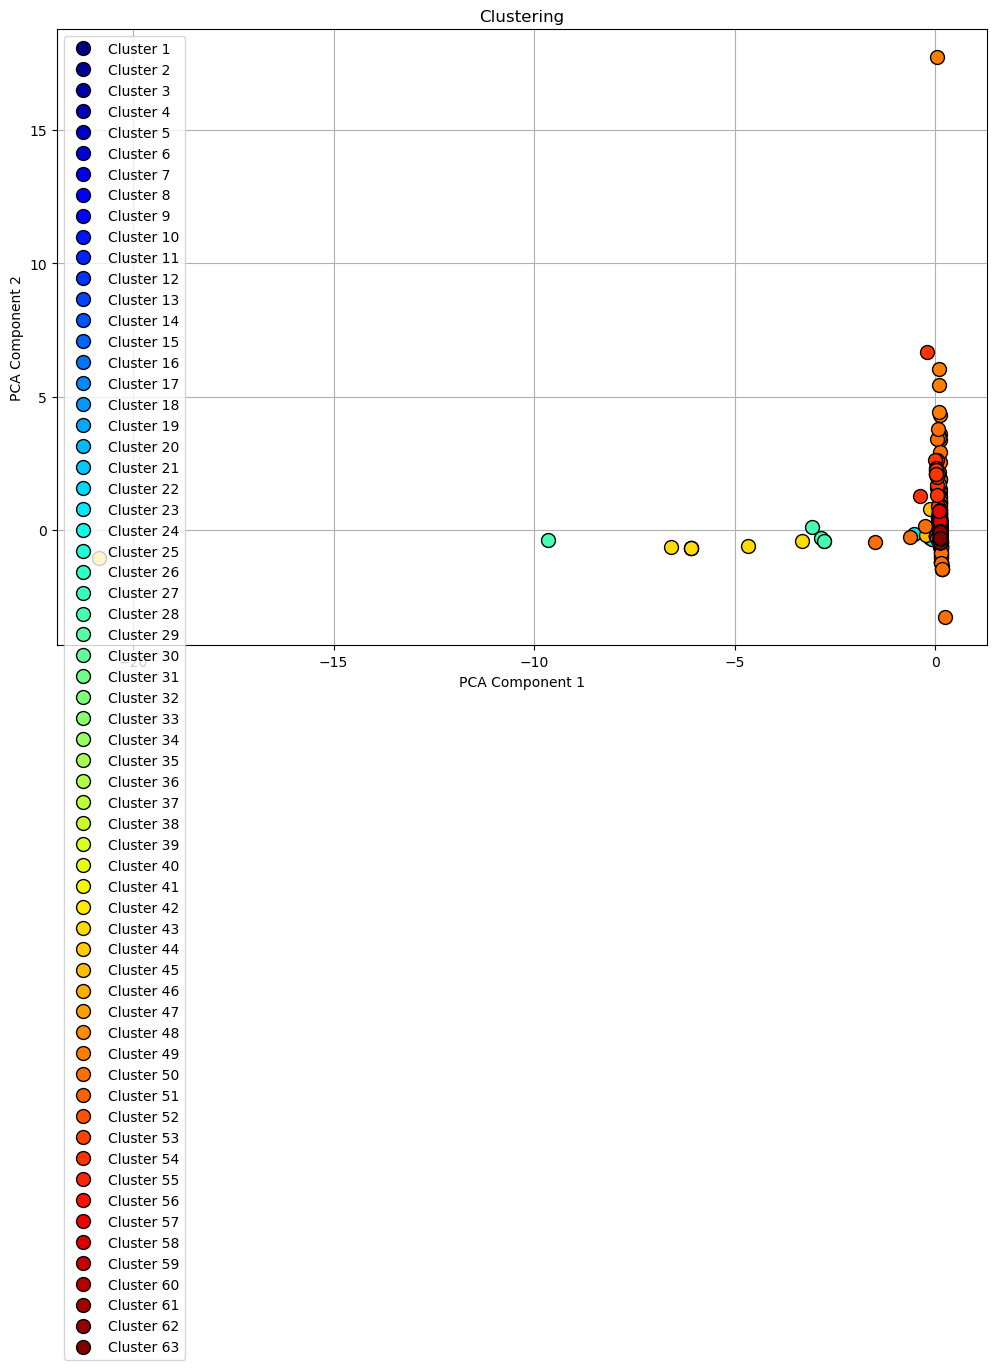

In [64]:
plot_clusters(spectral_embedding, spec_fclusters)

In [65]:
matices(X, spec_fclusters)

Metric     Score
0         Silhouette Score -0.290648
1  Calinski-Harabasz Index  1.582792
2     Davies-Bouldin Index  2.683453